# Imports and Load Data

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import seaborn as sns

In [176]:
splits_df = pd.read_csv('data/mj_splits_training_testing.csv')
labels    = np.repeat(np.array(splits_df['label']), 2)
training  = np.repeat(np.array(splits_df['training']), 2)
names     = np.repeat(np.array(splits_df['subject']), 2)

In [177]:
train_file = np.load("data/standard_fcs_labels_training.npz")

labels = train_file["labels"]
inputs = train_file["standard_fcs"]

len(labels), inputs.shape

(646, (646, 4005))

In [178]:
x_train, x_test = inputs[training == 1], inputs[training == 0]
y_train, y_test = labels[training == 1], labels[training == 0]

x_train.shape, x_test.shape

((516, 4005), (130, 4005))

In [125]:
import utils as uu
import importlib
importlib.reload(uu)

<module 'utils' from '/Users/nikash/PycharmProjects/functional_connectivity_analysis/utils.py'>

In [21]:
import sklearn.linear_model

# Grid Search Over Linear Models

In [22]:
searcher = uu.GridSearchHyperParameters({"alpha": (0.001, 1, 100)})

In [654]:
searcher.fivefold_crossvalid_solve(x_train, y_train, lambda alpha: sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=alpha))

 currently processing param 99/100, fold 4/5


[(0.021181818181818184,), 0.7016990291262137]

In [655]:
searcher.fivefold_crossvalid_solve(x_train, y_train, lambda alpha: sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=alpha))

 currently processing param 99/100, fold 4/5


[(0.28354545454545454,), 0.7267550410754294]

In [656]:
searcher.fivefold_crossvalid_solve(x_train, y_train, lambda alpha: sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=alpha))

 currently processing param 99/100, fold 4/5


[(0.011090909090909092,), 0.674570575056012]

In [657]:
searcher.fivefold_crossvalid_solve(x_train, y_train, lambda alpha: sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=alpha))

 currently processing param 99/100, fold 4/5


[(0.1220909090909091,), 0.722890216579537]

# K-Fold Cross Validation With Best Hyperparameters

In [296]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import sklearn.ensemble
import sklearn.cross_decomposition

In [507]:
class_weight = None#{0: 0.6, 1: 0.4}
# best hyperparameters: l1_svm: 0.02, l2_svm: 0.2, l1_logr: 0.01, l2_logr: 0.1

model_l1_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l1_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001, max_iter=1000000, random_state=1, class_weight=class_weight)
model_l2_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.05, max_iter=1000000, random_state=1, class_weight=class_weight)
model_pls = sklearn.cross_decomposition.PLSRegression(5)

model_rf = sklearn.ensemble.RandomForestClassifier()

models = {"Logstic Regression L1": model_l1_logr, "Logistic Regression L2": model_l2_logr, 
          "Support VM L1":model_l1_svm, "Support VM L2": model_l2_svm}

 Training model Logistic Regression L2, fold 7/10

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/_plotting.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


 Training model Support VM L2, fold 9/10fold 9/10

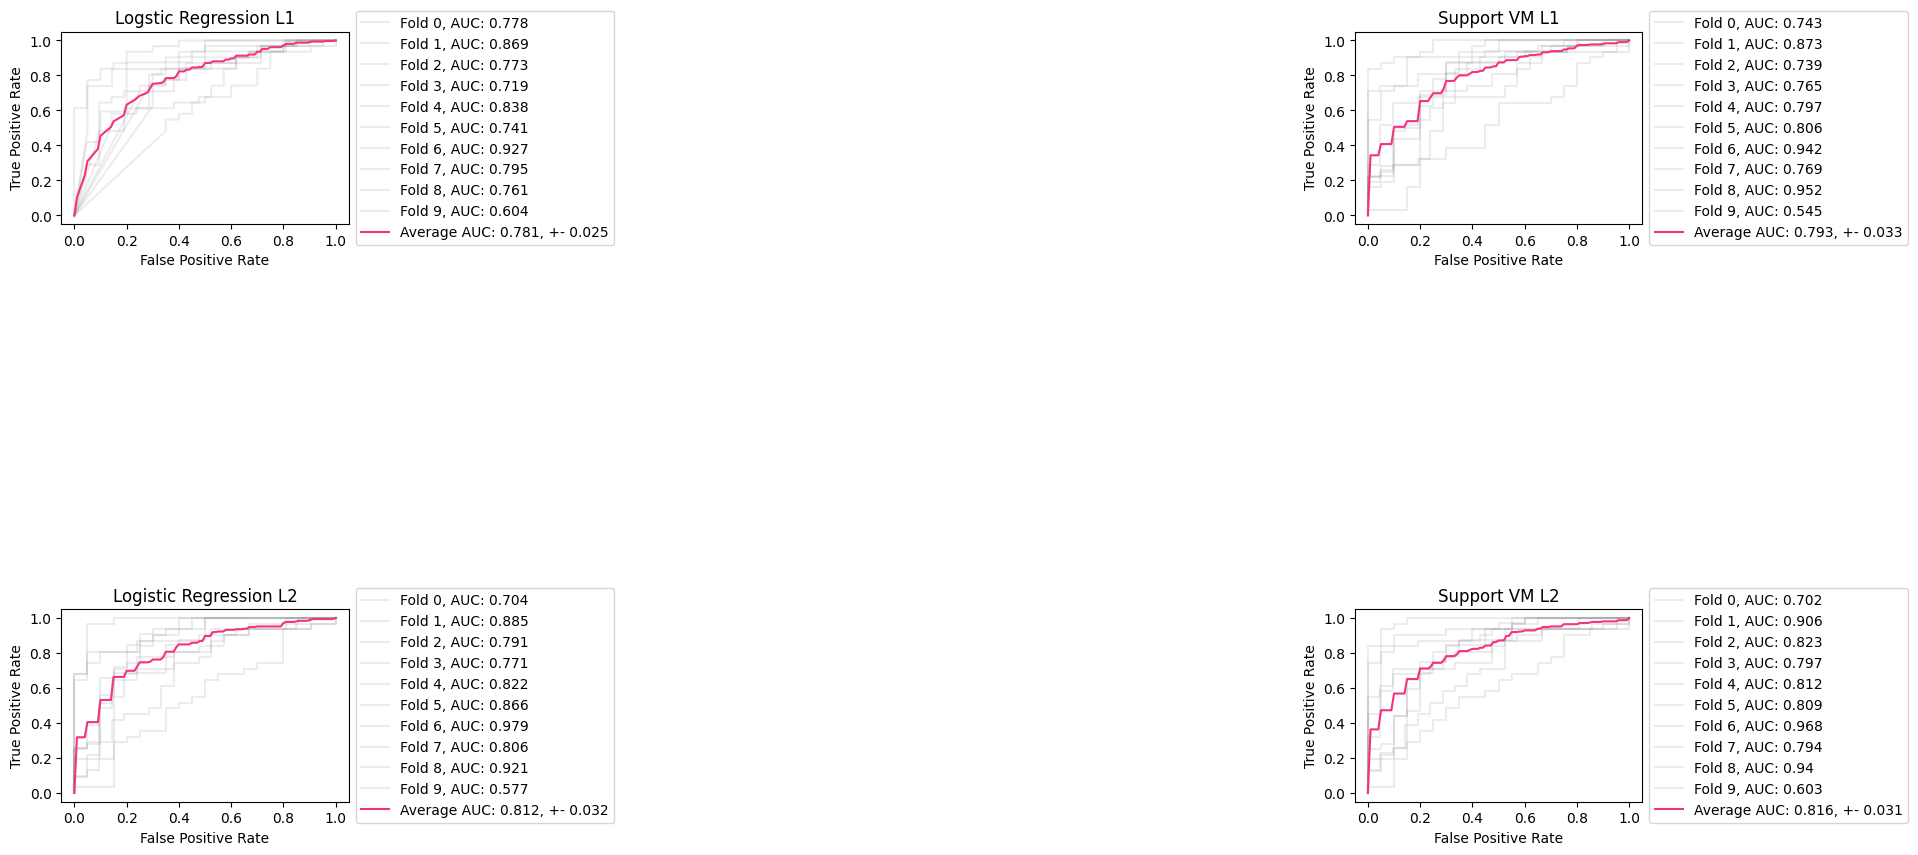

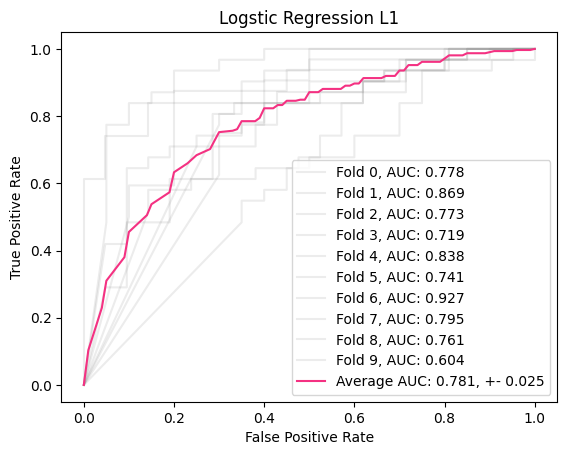

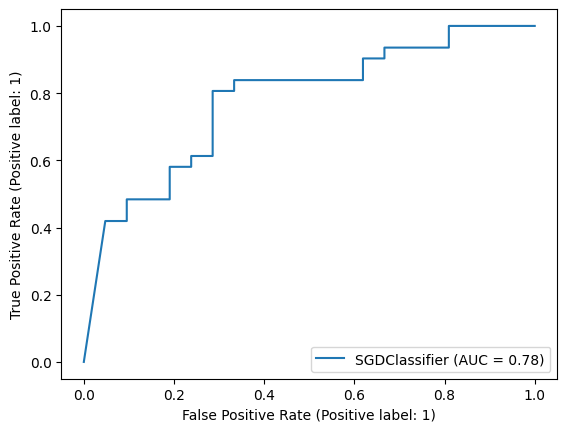

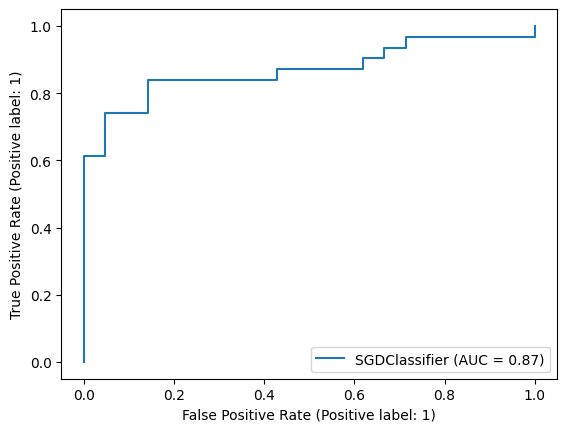

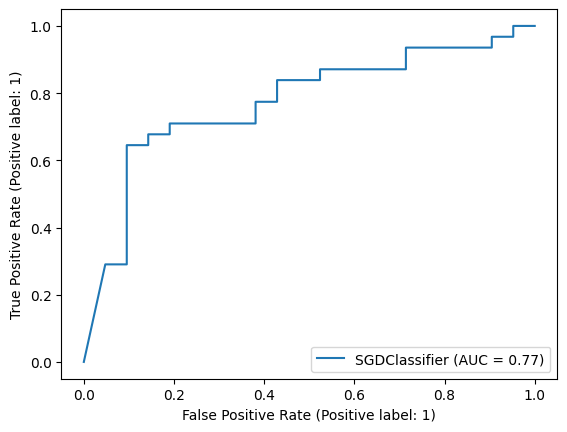

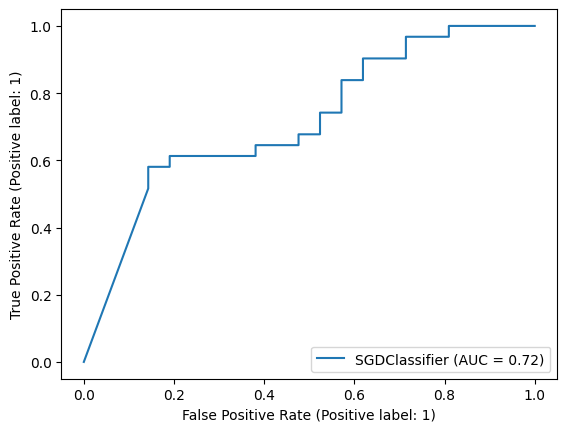

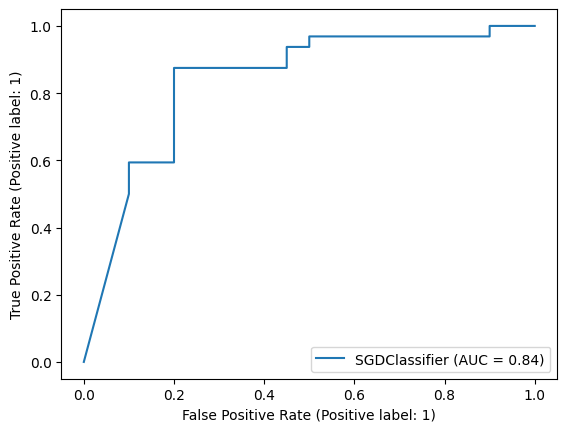

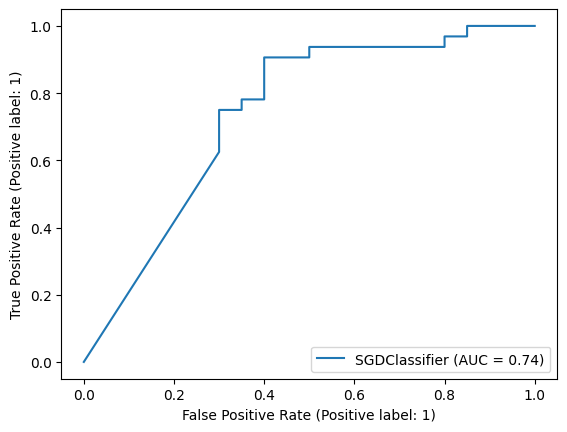

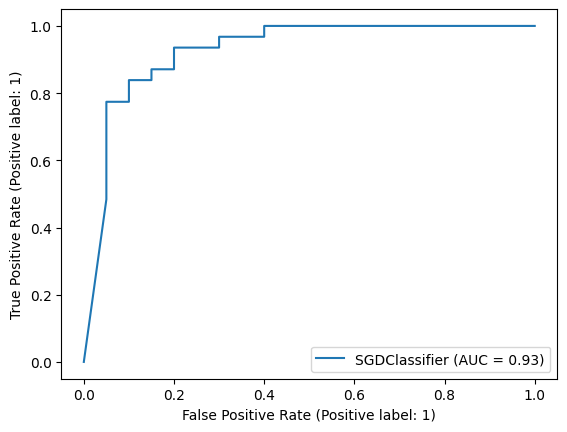

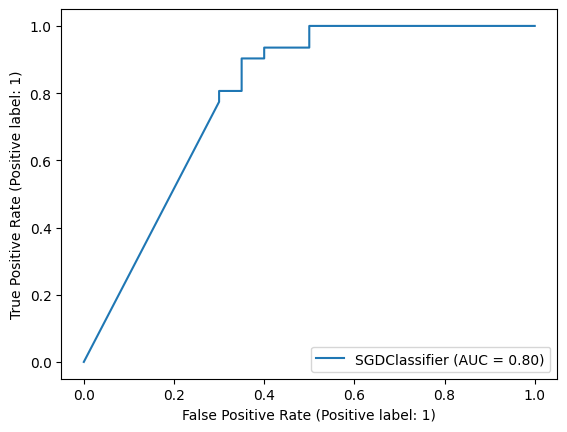

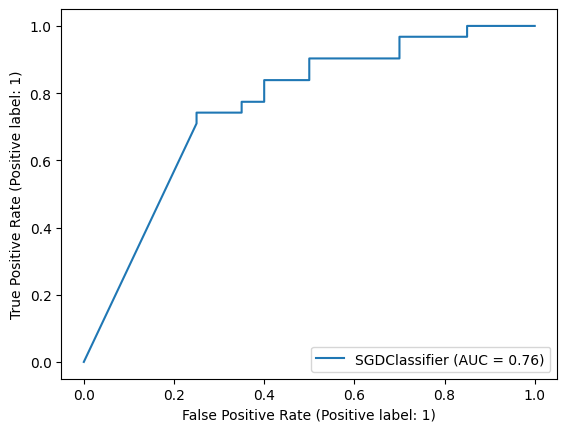

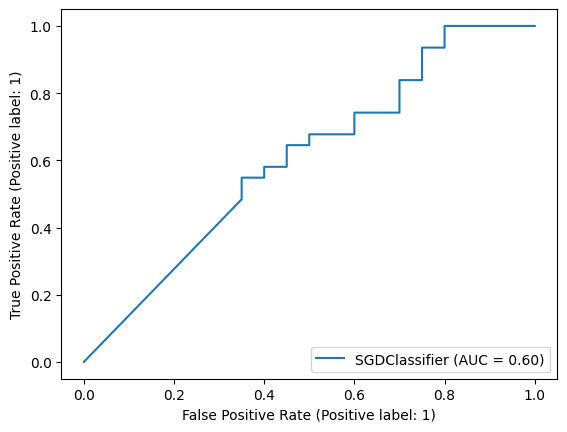

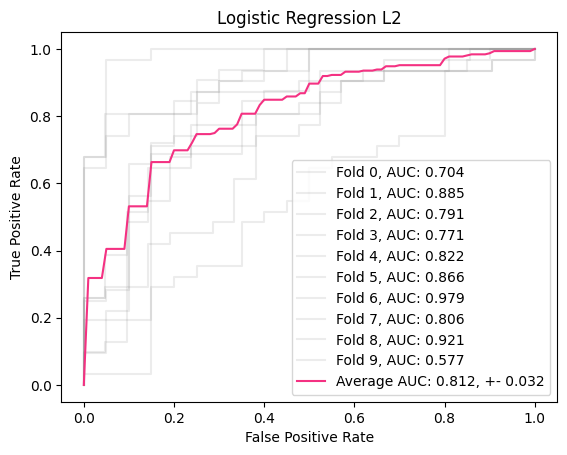

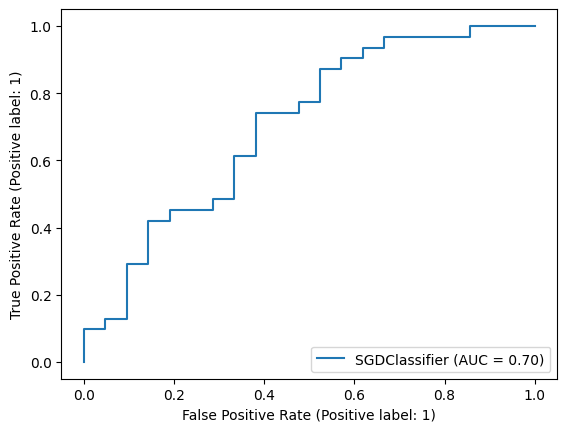

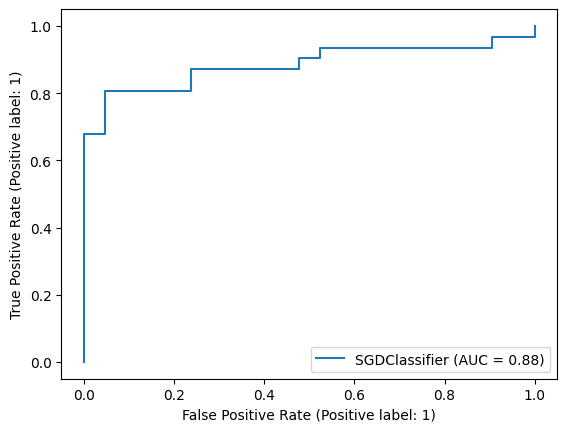

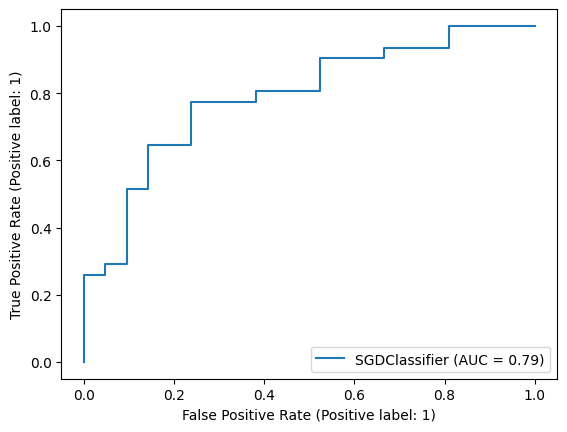

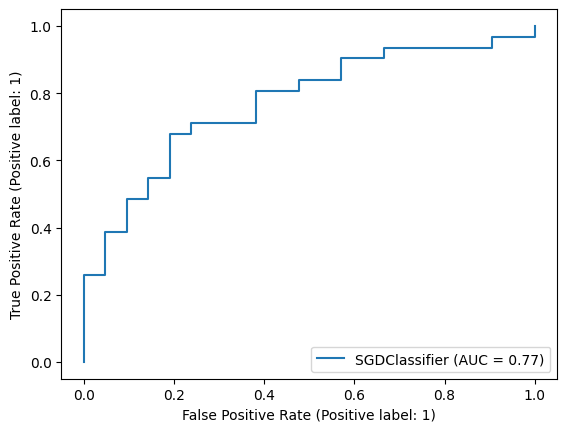

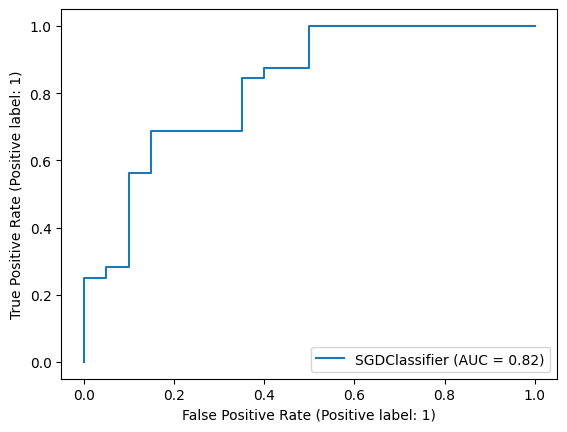

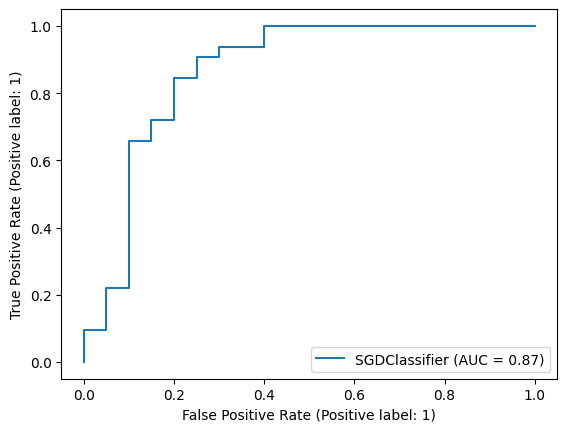

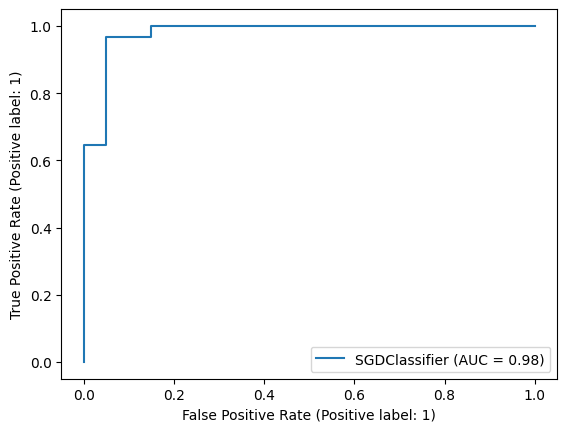

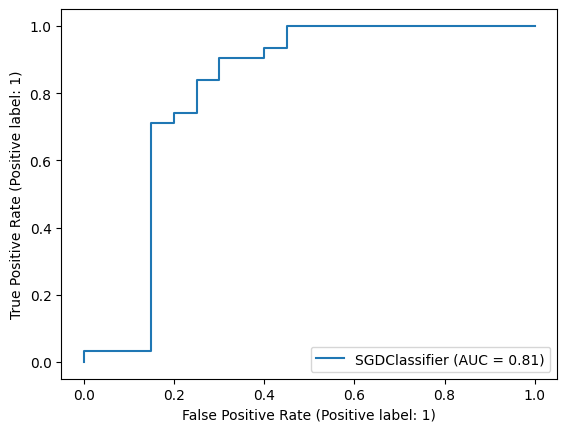

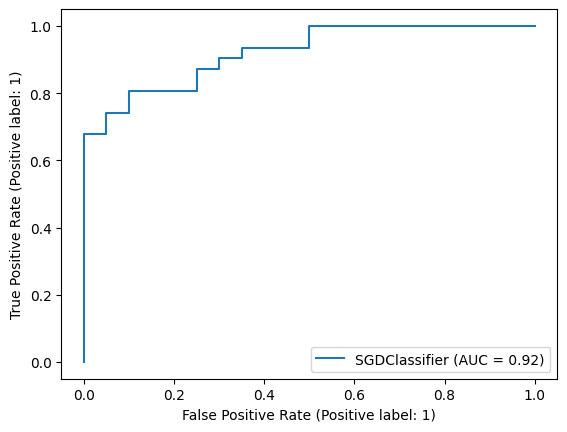

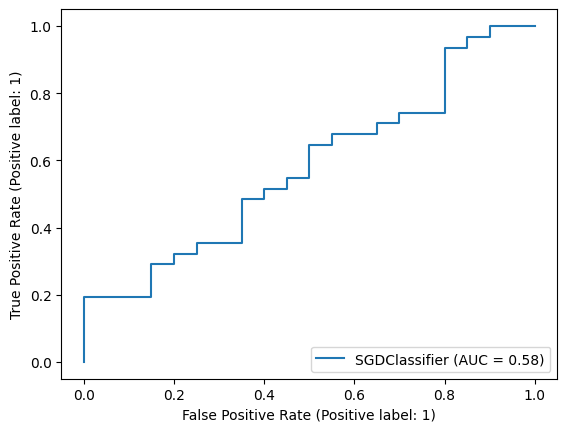

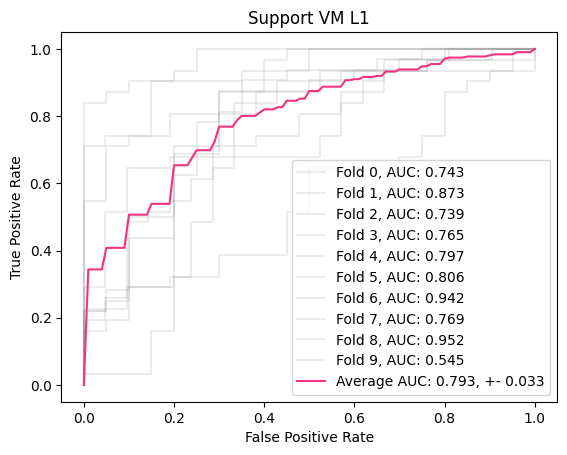

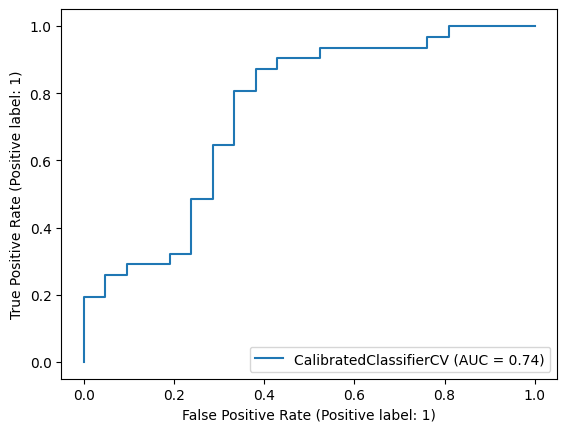

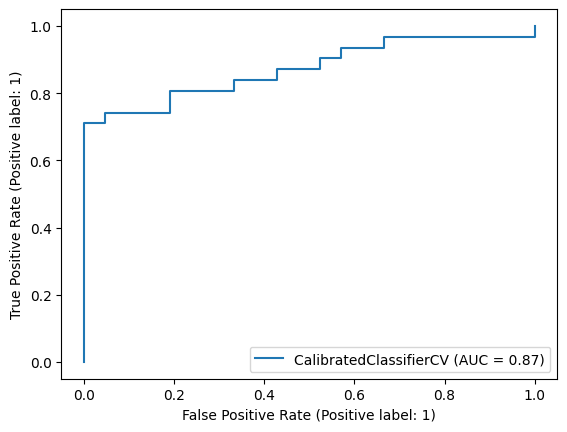

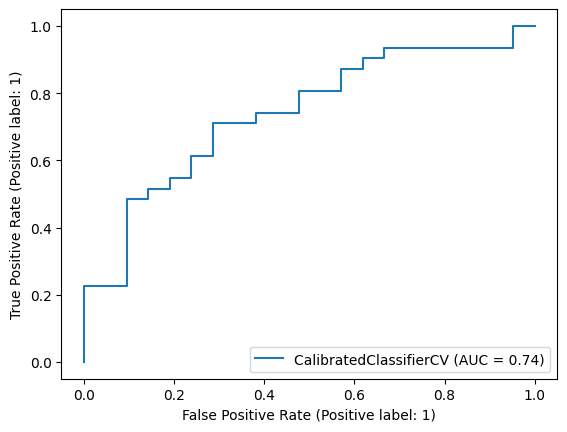

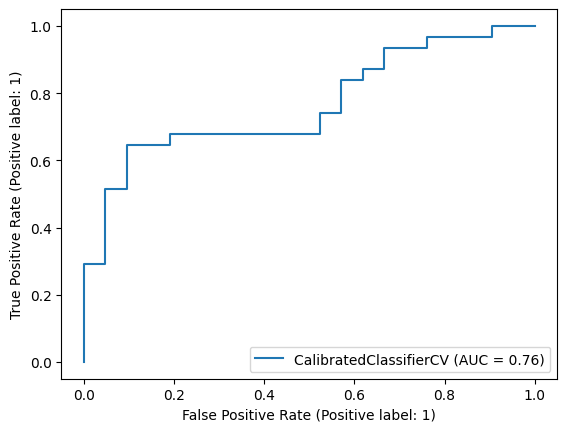

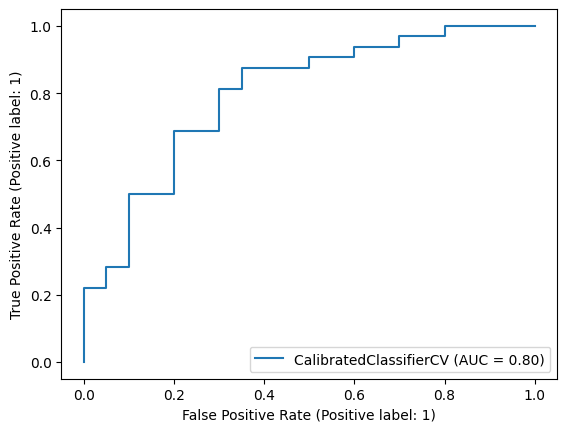

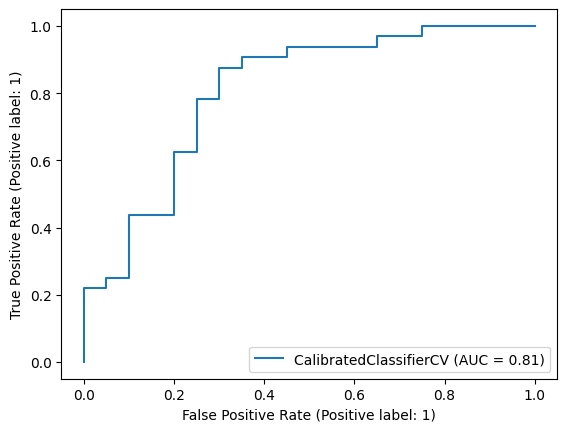

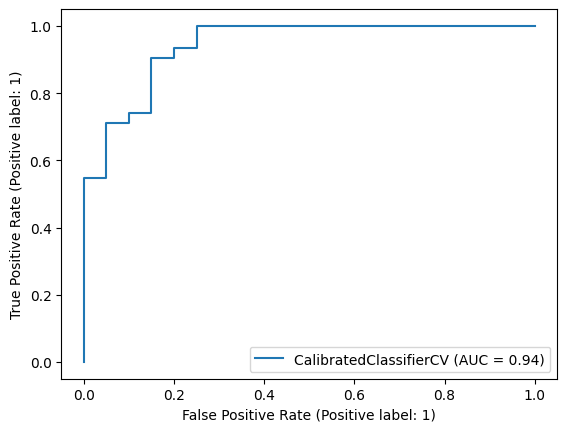

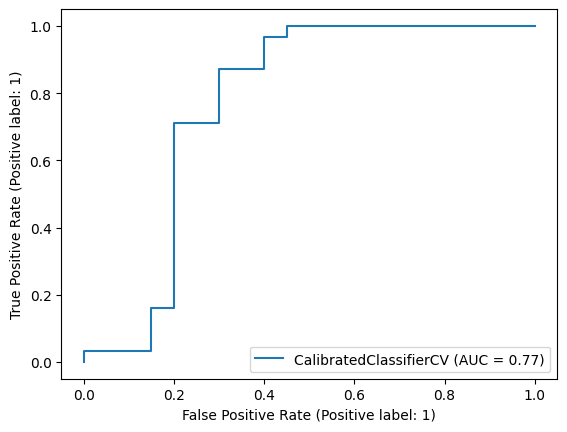

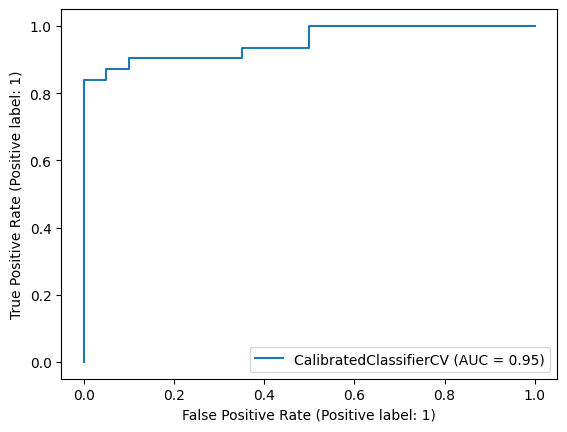

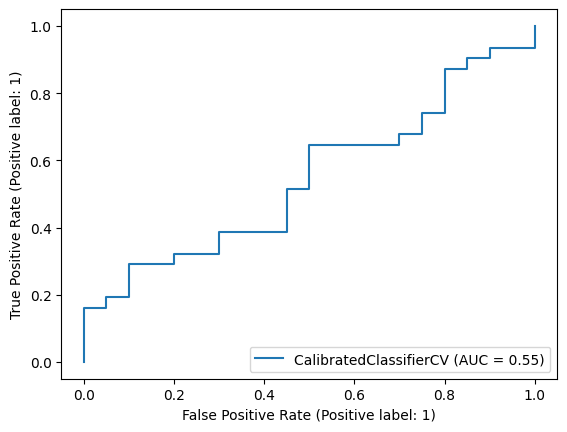

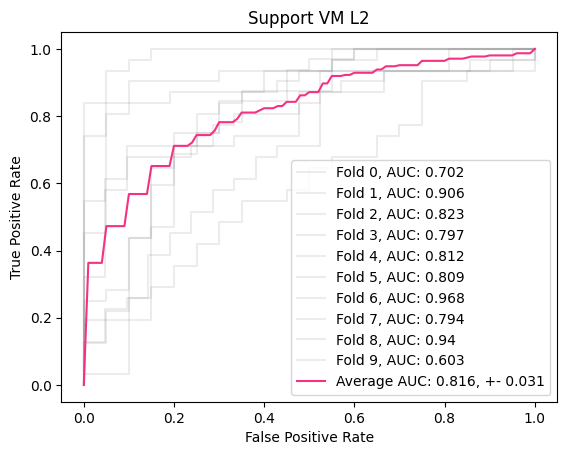

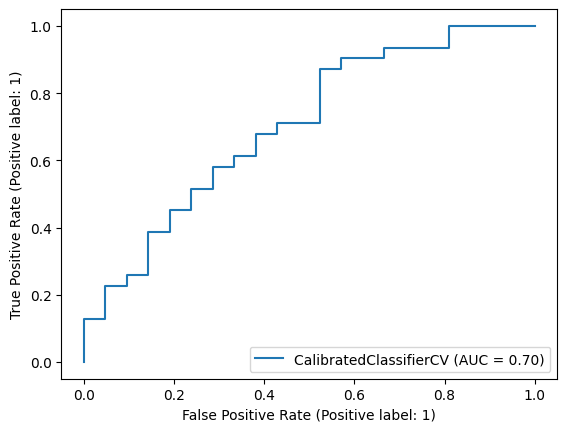

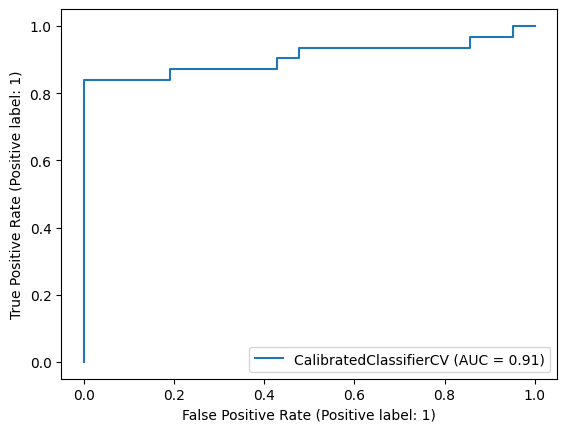

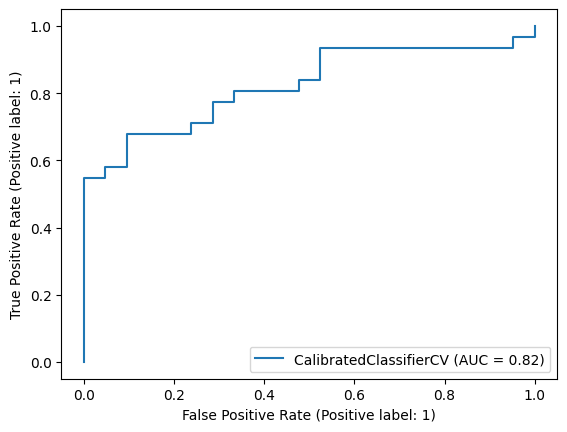

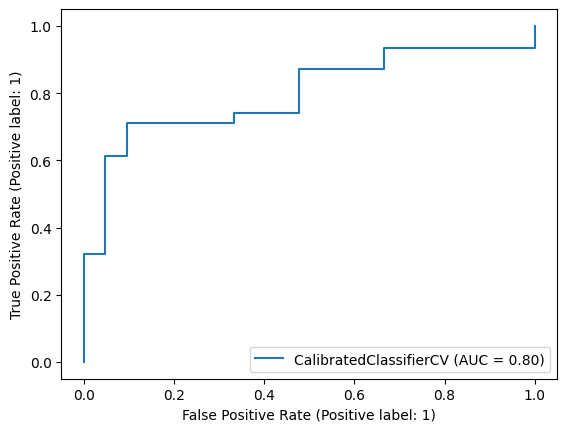

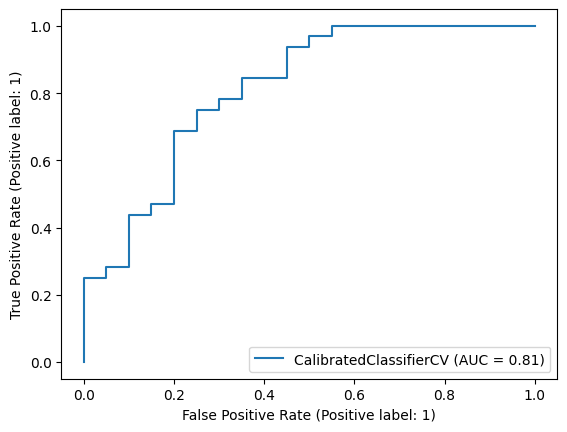

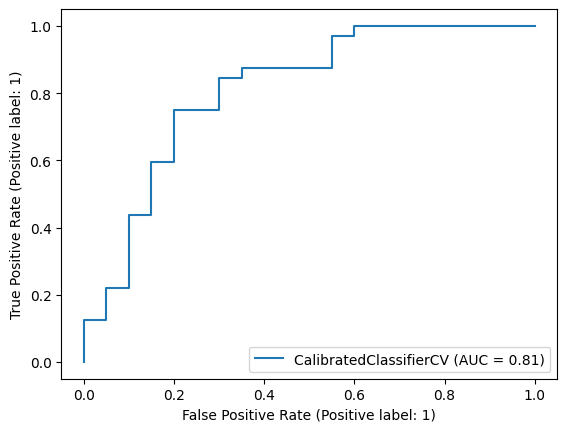

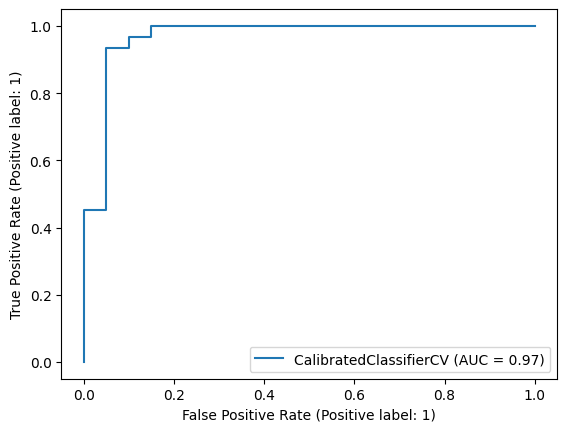

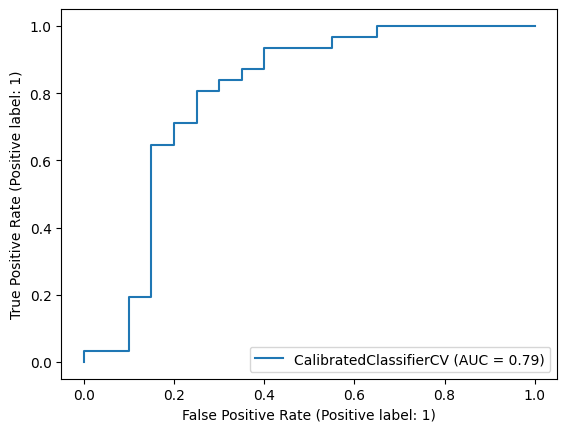

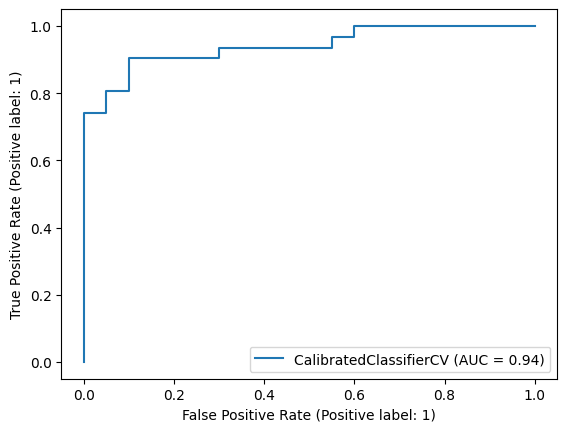

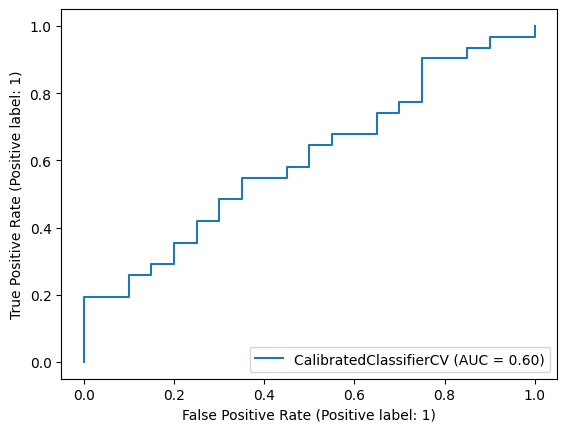

In [508]:
metrics = {
    "accuracy": lambda yh, pyh, y: sklearn.metrics.accuracy_score(y, yh), 
    "auc": lambda yh, pyh, y: sklearn.metrics.roc_auc_score(y, pyh)         
}

folds = 10
tot_fig, tot_ax = plt.subplots(2, 2, figsize=(17, 10))

train_metrics = {}
for ax_idx, (model_name, model) in enumerate(models.items()):
    skf = uu.StratifiedKFold(n_splits=folds)

    fig, ax = plt.subplots()

    train_metrics[model_name] = {}

    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    for j, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
        train_metrics[model_name][j] = {}
        model_cln = CalibratedClassifierCV(uu.clone(model)) if "VM" in model_name else uu.clone(model)

        fold_x_train, fold_x_test = x_train[train_index], x_train[test_index]
        fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

        model_cln.fit(fold_x_train, fold_y_train)
        test_pred = model_cln.predict(fold_x_test) if "pls" not in model_name else np.round(model_cln.predict(fold_x_test)[:, 0])
        test_pred_probs = model_cln.predict_proba(fold_x_test)[:, 1] if "pls" not in model_name else model_cln.predict(fold_x_test)[:, 0]
        
        for metric_name, metric_fn in metrics.items():
            train_metrics[model_name][j][metric_name] = metric_fn(test_pred, test_pred_probs, fold_y_test)

        viz_data = sklearn.metrics.RocCurveDisplay.from_estimator(model_cln, fold_x_test, fold_y_test) if "pls" not in model_name else \
                    sklearn.metrics.RocCurveDisplay.from_predictions(fold_y_test, test_pred_probs)
        fpr = viz_data.fpr
        tpr = viz_data.tpr

        train_metrics[model_name][j]["fpr_tpr"] = (fpr, tpr)
        train_metrics[model_name][j]["auc"] = viz_data.roc_auc

        roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Fold {j}, AUC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        tot_ax[ax_idx%2, ax_idx//2].plot(fpr, tpr, alpha=0.15, color="gray", label=f"Fold {j}, AUC: {np.round(train_metrics[model_name][j]['auc'], 3)}")
        train_metrics[model_name][j]["roc_plot"] = roc

        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

        print("\r", f"Training model {model_name}, fold {j}/{folds}", end="")

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    aucs = [m['auc'] for _, m in train_metrics[model_name].items()]
    mean_auc = np.mean(aucs)
    sd_auc = np.std(aucs)

    ci = 0.95 * sd_auc / np.sqrt(len(aucs))

    ax.plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)  
    tot_ax[ax_idx%2, ax_idx//2].plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
    box = tot_ax[ax_idx%2, ax_idx//2].get_position()
    tot_ax[ax_idx%2, ax_idx//2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    tot_ax[ax_idx%2, ax_idx//2].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))


    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)
    tot_ax[ax_idx%2, ax_idx//2].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=model_name)

    train_metrics[model_name]["roc_curve"] = fig

tot_fig.subplots_adjust(left=0.07, right=1, wspace=3.5, hspace=2)

In [509]:
tot_fig.tight_layout()
tot_fig.savefig("out_plot.png")

In [512]:
train_metrics

{'Logstic Regression L1': {0: {'accuracy': 0.7692307692307693,
   'auc': 0.7780337941628264,
   'fpr_tpr': (array([0.        , 0.04761905, 0.0952381 , 0.0952381 , 0.19047619,
           0.19047619, 0.23809524, 0.23809524, 0.28571429, 0.28571429,
           0.33333333, 0.33333333, 0.61904762, 0.61904762, 0.66666667,
           0.66666667, 0.80952381, 0.80952381, 1.        ]),
    array([0.        , 0.41935484, 0.41935484, 0.48387097, 0.48387097,
           0.58064516, 0.58064516, 0.61290323, 0.61290323, 0.80645161,
           0.80645161, 0.83870968, 0.83870968, 0.90322581, 0.90322581,
           0.93548387, 0.93548387, 1.        , 1.        ])),
   'roc_plot': [<matplotlib.lines.Line2D at 0x7f9fdcae8310>]},
  1: {'accuracy': 0.7884615384615384,
   'auc': 0.8694316436251921,
   'fpr_tpr': (array([0.        , 0.        , 0.        , 0.04761905, 0.04761905,
           0.14285714, 0.14285714, 0.42857143, 0.42857143, 0.61904762,
           0.61904762, 0.66666667, 0.66666667, 0.71428571, 0.71

In [519]:
{n:np.mean([l["accuracy"] for _, l in m.items() if type(_) == int]) for n, m in train_metrics.items() if n != "roc_curve"}

{'Logstic Regression L1': 0.7499622926093515,
 'Logistic Regression L2': 0.7403846153846155,
 'Support VM L1': 0.7384615384615384,
 'Support VM L2': 0.7481900452488688}

# Retrain With Best Hyperparameters On All Train Data

In [572]:
import sklearn.ensemble

class_weight = {0: 0.6, 1: 0.4}
rs = 1
model_l1_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l1", alpha=0.001, max_iter=1000000, random_state=rs, class_weight=class_weight)
model_l2_svm = sklearn.linear_model.SGDClassifier(loss="hinge", penalty="l2", alpha=0.05, max_iter=1000000, random_state=rs, class_weight=class_weight)
#model_l1_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001, max_iter=1000000, random_state=rs, class_weight=class_weight)
model_l1_logr = sklearn.linear_model.LogisticRegression(penalty="l1", max_iter=5000, 
                                                   random_state=rs, solver="saga")
model_l2_logr = sklearn.linear_model.SGDClassifier(loss="log_loss", penalty="l2", alpha=0.05, max_iter=1000000, random_state=rs, class_weight=class_weight)
model_pls = sklearn.cross_decomposition.PLSRegression(5)

models = {"l1_logr":model_l1_logr, "l2_logr": model_l2_logr, 
          "l1_svm":model_l1_svm, "l2_svm": model_l2_svm, "pls": model_pls}

for model_name, model in models.items():
    print(f"fitting {model_name}")
    model.fit(x_train, y_train)
    
print("")
print("finished")

fitting l1_logr
fitting l2_logr
fitting l1_svm
fitting l2_svm
fitting pls

finished


l1_logr, accuracy: 0.7846153846153846, auc: 0.8641518737672584
l2_logr, accuracy: 0.8, auc: 0.875
l1_svm, accuracy: 0.823076923076923, auc: 0.8789447731755424
l2_svm, accuracy: 0.823076923076923, auc: 0.8851084812623274
pls, accuracy: 0.823076923076923, auc: 0.8991617357001973


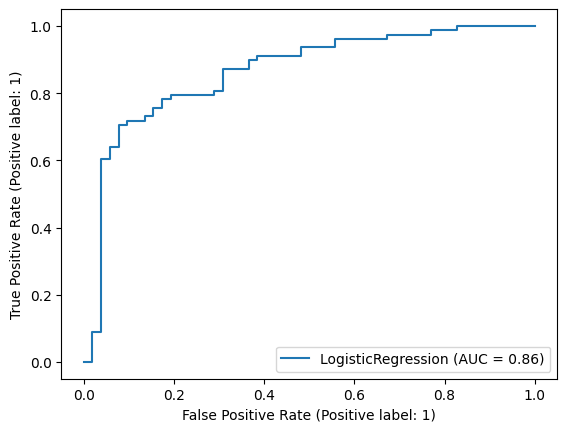

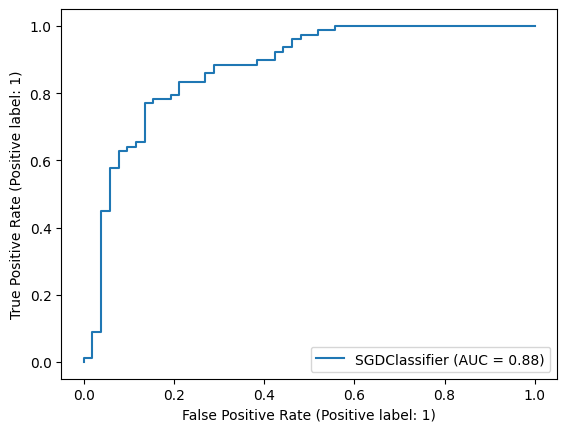

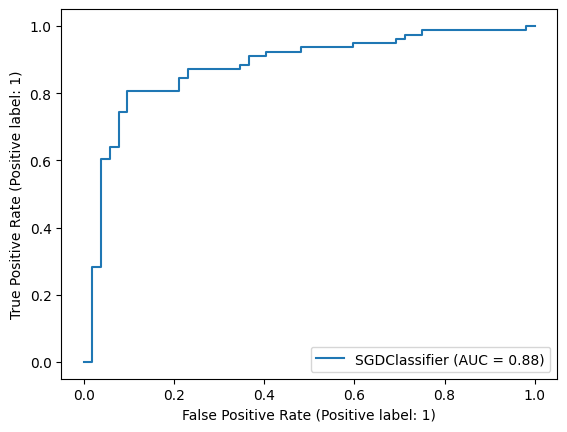

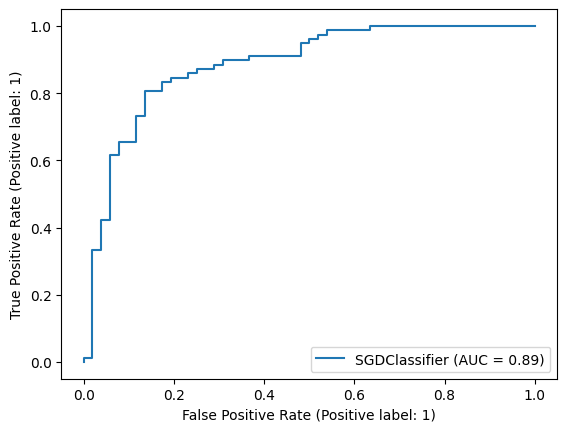

In [575]:
for model_name, model in models.items():
    if "pls" in model_name:
        acc = np.mean(np.round(model.predict(x_test))[:, 0] == y_test)
        auc = sklearn.metrics.roc_auc_score(y_test, model.predict(x_test)[:, 0])
        print(f"{model_name}, accuracy: {acc}, auc: {auc}")
        continue
        
    print(f"{model_name}, accuracy: {model.score(x_test, y_test)}, auc: {sklearn.metrics.RocCurveDisplay.from_estimator(model, x_test, y_test).roc_auc}")

# Control Analysis

Text(0.5, 0.98, 'Control Degree Centrality Of FCMS')

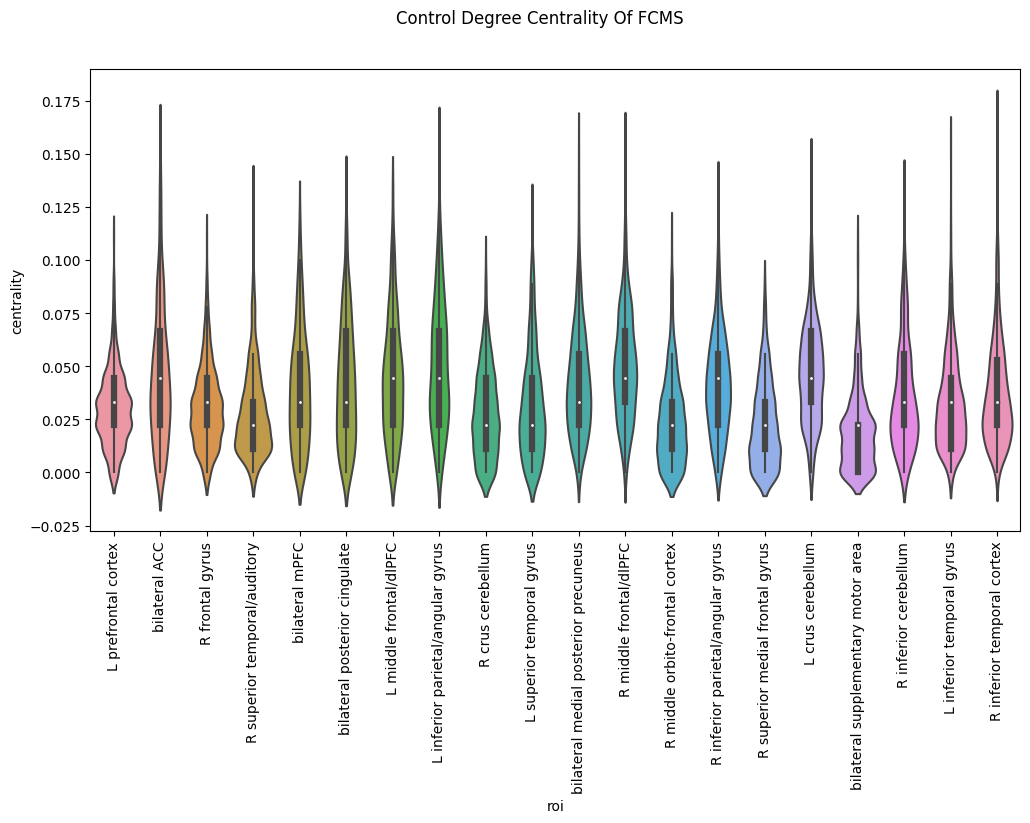

In [138]:
import heavytools as hv


fcms, bcs = hv.get_brain_connectivity_functional_connectivity(inputs, 0)
thresh_bcs = [hv.binarize(hv.threshold(b)) for b in bcs]

centrals = np.array([hv.degree_centrality(b) for b in thresh_bcs])
median_centrals = np.median(centrals.T, axis=1)

indices = np.argpartition(median_centrals, -20)[-20:]
df = hv.convert_centralities_to_df(centrals, indices)

control_centrals = centrals

fig = plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality")
plt.xticks(rotation=90)

fig.suptitle("Control Degree Centrality Of FCMS")

In [32]:
os.makedirs("out/functional_connectivity/control", exist_ok=True)
with open("out/functional_connectivity/control/thresh_fcms.npy", "wb+") as f:
    np.save(f, thresh_bcs)
with open("out/functional_connectivity/control/fcms.npy", "wb+") as f:
    np.save(f, bcs)

Text(0.5, 0.98, 'Control Degree Centrality Of FCMS')

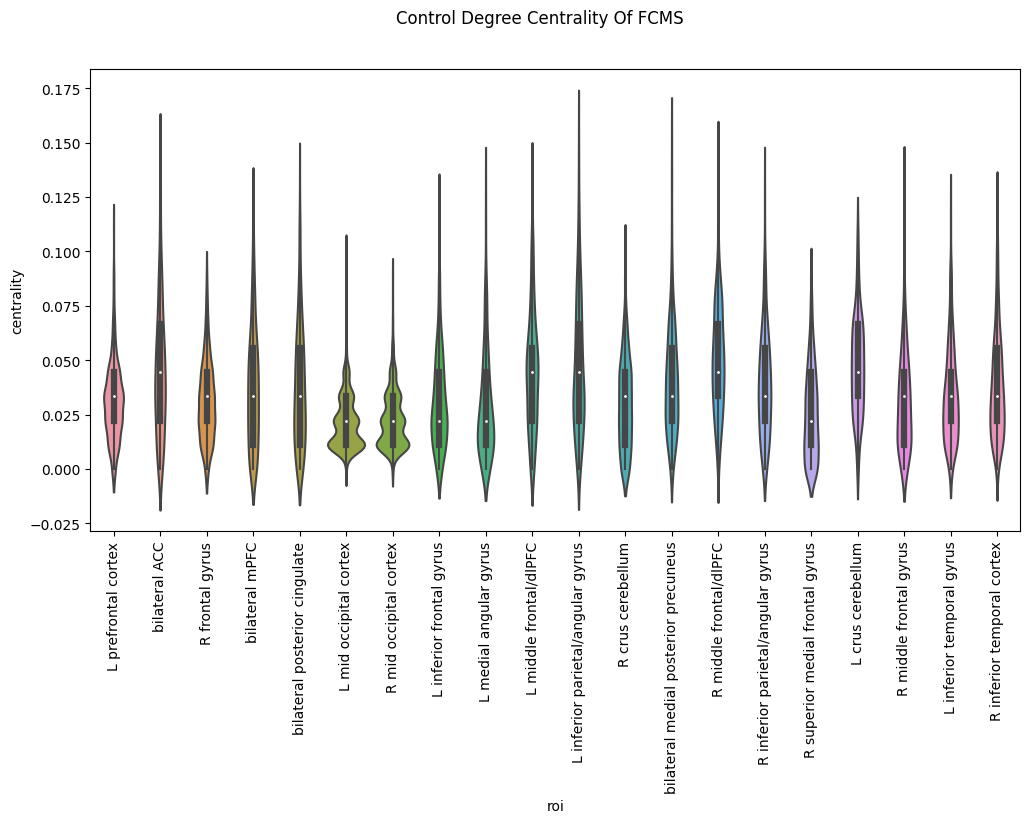

In [33]:
import heavytools as hv


fcms, bcs = hv.get_brain_connectivity_functional_connectivity(inputs[labels==1], 0)
thresh_bcs = [hv.binarize(hv.threshold(b)) for b in bcs]

centrals = np.array([hv.degree_centrality(b) for b in thresh_bcs])
median_centrals = np.median(centrals.T, axis=1)

indices = np.argpartition(median_centrals, -20)[-20:]
df = hv.convert_centralities_to_df(centrals, indices)

control_centrals = centrals

fig = plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality")
plt.xticks(rotation=90)

fig.suptitle("Control Degree Centrality Of FCMS")

In [34]:
os.makedirs("out/functional_connectivity/control", exist_ok=True)
with open("out/functional_connectivity/control/cu_thresh_fcms.npy", "wb+") as f:
    np.save(f, thresh_bcs)
with open("out/functional_connectivity/control/cu_fcms.npy", "wb+") as f:
    np.save(f, bcs)

Text(0.5, 0.98, 'Control Degree Centrality Of FCMS')

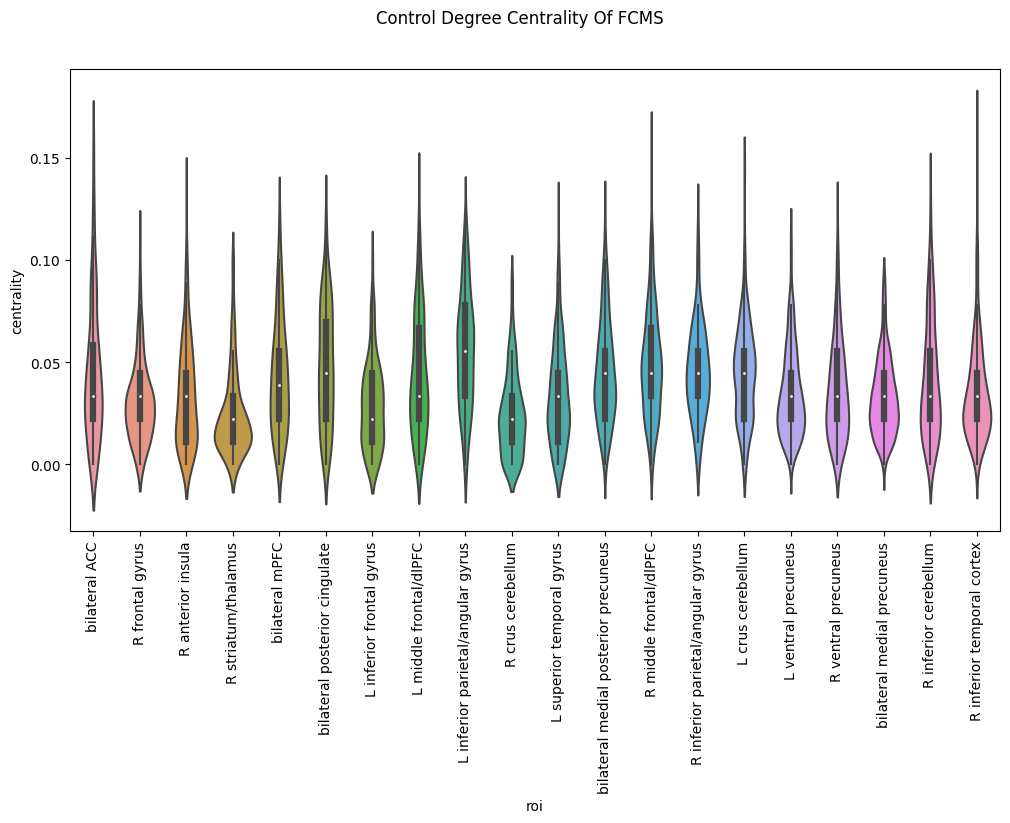

In [35]:
import heavytools as hv


fcms, bcs = hv.get_brain_connectivity_functional_connectivity(inputs[labels==0], 0)
thresh_bcs = [hv.binarize(hv.threshold(b)) for b in bcs]

centrals = np.array([hv.degree_centrality(b) for b in thresh_bcs])
median_centrals = np.median(centrals.T, axis=1)

indices = np.argpartition(median_centrals, -20)[-20:]
df = hv.convert_centralities_to_df(centrals, indices)

control_centrals = centrals

fig = plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality")
plt.xticks(rotation=90)

fig.suptitle("Control Degree Centrality Of FCMS")

In [36]:
os.makedirs("out/functional_connectivity/control", exist_ok=True)
with open("out/functional_connectivity/control/hc_thresh_fcms.npy", "wb+") as f:
    np.save(f, thresh_bcs)
with open("out/functional_connectivity/control/hc_fcms.npy", "wb+") as f:
    np.save(f, bcs)

# Weights Analysis With Best Performing Model

In [545]:
import heavytools as hv
importlib.reload(hv)

<module 'heavytools' from '/Users/nikash/PycharmProjects/functional_connectivity_analysis/heavytools.py'>

In [558]:
model_analyze = model_l2_svm
model_analyze

SGDClassifier(alpha=0.05, class_weight={0: 0.6, 1: 0.4}, max_iter=1000000,
              random_state=1)

In [559]:
model_analyze.__dict__

{'loss': 'hinge',
 'penalty': 'l2',
 'learning_rate': 'optimal',
 'epsilon': 0.1,
 'alpha': 0.05,
 'C': 1.0,
 'l1_ratio': 0.15,
 'fit_intercept': True,
 'shuffle': True,
 'random_state': 1,
 'verbose': 0,
 'eta0': 0.0,
 'power_t': 0.5,
 'early_stopping': False,
 'validation_fraction': 0.1,
 'n_iter_no_change': 5,
 'warm_start': False,
 'average': False,
 'max_iter': 1000000,
 'tol': 0.001,
 'class_weight': {0: 0.6, 1: 0.4},
 'n_jobs': None,
 'coef_': array([[ 0.02860132,  0.02170984, -0.01727852, ..., -0.00653304,
          0.04034946,  0.00510208]]),
 'intercept_': array([-1.16624216]),
 't_': 22189.0,
 'n_features_in_': 4005,
 'classes_': array([0, 1]),
 '_expanded_class_weight': array([0.6, 0.4]),
 'loss_function_': <sklearn.linear_model._sgd_fast.Hinge at 0x7f9fe5167390>,
 'n_iter_': 43}

In [560]:
model_analyze.coef_.shape

(1, 4005)

In [561]:
weights = hv.convert_triangle_to_mat(np.abs(model_analyze.coef_[0]))
weights.shape

(90, 90)

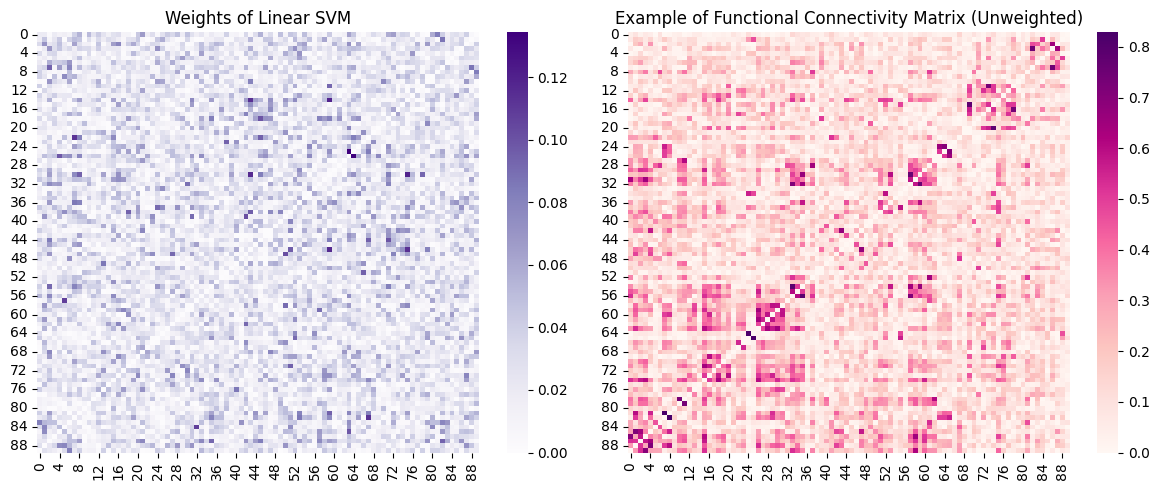

In [562]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(np.rot90(weights), cmap="Purples", ax=ax[0])
sns.heatmap(np.rot90(np.abs(hv.convert_triangle_to_mat(x_test[17]))), cmap="RdPu", ax=ax[1])

ax[0].set(title="Weights of Linear SVM")
ax[1].set(title="Example of Functional Connectivity Matrix (Unweighted)")
fig.tight_layout()

<Axes: >

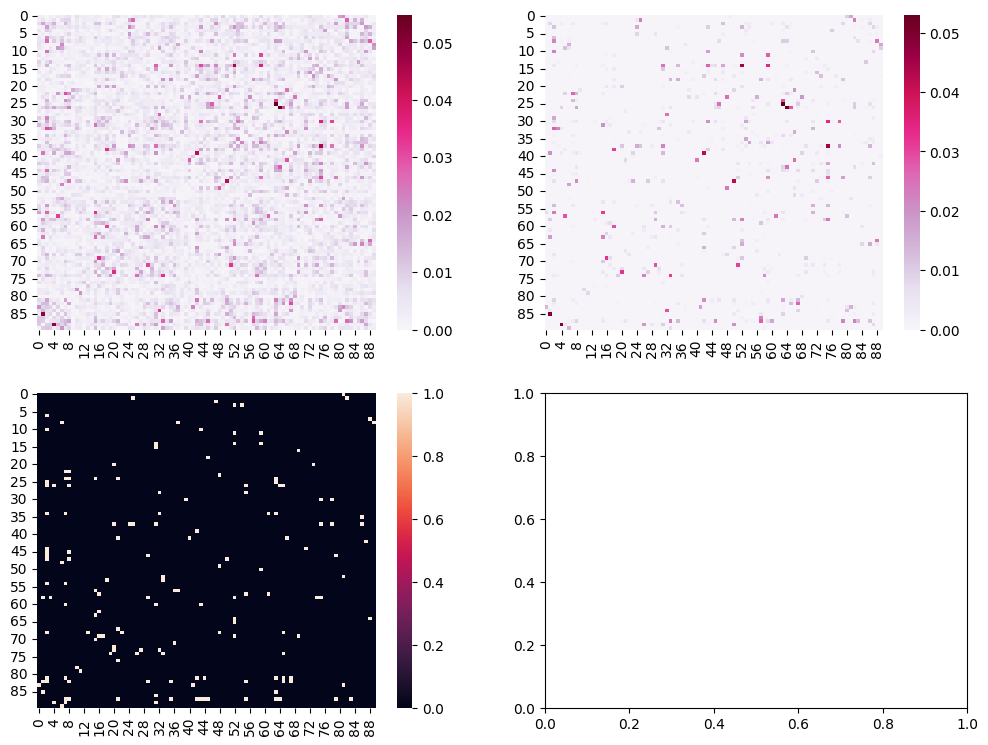

In [563]:
fcms, bcs = hv.get_brain_connectivity_functional_connectivity(inputs, weights)
fcms_thresh = [hv.threshold(f, 0.02) for f in fcms]
binarized_fcms_thresh = [hv.binarize(f) for f in fcms_thresh]


fig, ax = plt.subplots(2, 2, figsize=(12, 9))
sns.heatmap(np.rot90(np.mean(fcms, axis=0)), cmap="PuRd", ax=ax[0, 0])
sns.heatmap(np.rot90(np.mean(fcms_thresh, axis=0)), cmap="PuRd", ax=ax[0, 1])
sns.heatmap(np.rot90(binarized_fcms_thresh[0]), ax=ax[1, 0])

# sns.heatmap(np.rot90(fcms[17]), cmap="PuRd", ax=ax[0])
# sns.heatmap(np.rot90(fcms_thresh[17]), cmap="PuRd", ax=ax[1])

[Text(0.5, 0, 'ROI'), Text(0, 0.5, 'Centrality')]

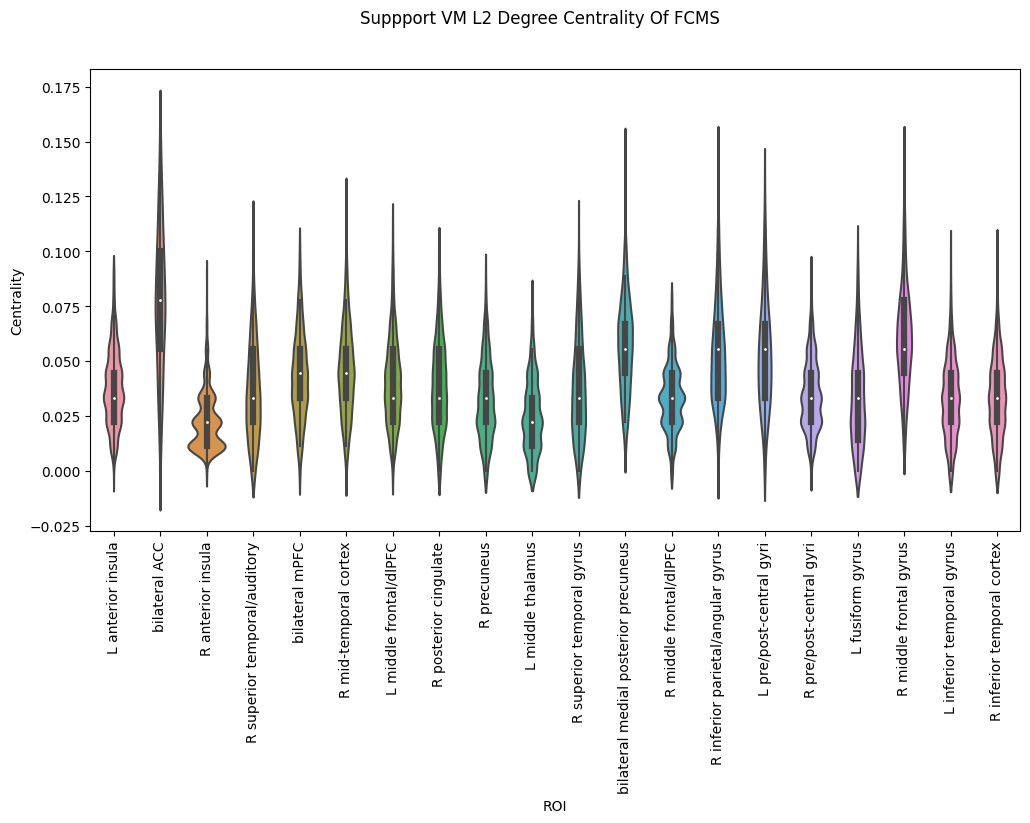

In [567]:
centrals = np.array([hv.degree_centrality(f) for f in binarized_fcms_thresh])
median_centrals = np.median(centrals.T, axis=1)

indices = np.argpartition(median_centrals, -20)[-20:]

df = hv.convert_centralities_to_df(centrals, indices)

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality")
plt.xticks(rotation=90)
fig.suptitle("Suppport VM L2 Degree Centrality Of FCMS")
ax.set(xlabel="ROI", ylabel="Centrality")

In [565]:
indices

array([ 4, 33, 45, 86, 82, 43,  8, 75, 15, 42, 71, 63,  1, 59, 57,  2, 31,
       52, 50, 64])

In [566]:
sims = [hv.cosim(centrals[i], control_centrals[i]) for i in range(centrals.shape[0])]
np.mean(sims)

0.7411350522351482

In [569]:
os.makedirs("out/functional_connectivity/l2_svm", exist_ok=True)
with open("out/functional_connectivity/l2_svm/thresh_fcms.npy", "wb+") as f:
    np.save(f, fcms_thresh)
with open("out/functional_connectivity/l2_svm/fcms.npy", "wb+") as f:
    np.save(f, fcms)

# Tensorflow NN Model (Interpretable)

In [424]:
import tensorflow as tf
import tensorflow.keras as keras

In [446]:
def build_model(seed=1, alpha=0.0001):
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    
    tf_model = keras.Sequential([
        keras.layers.Dense(1000, kernel_regularizer=tf.keras.regularizers.L2(alpha), activation=None),
        keras.layers.LeakyReLU(0.3),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.L2(alpha), activation=None),
        keras.layers.LeakyReLU(0.3),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.L2(alpha)),
    ])
    
    tf_model.build((None, 4005))
    return tf_model

tf_model = build_model(alpha=0.005)
tf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])

Epoch 1/4
15/15 [==============================] - 6s 112ms/step - loss: 7.8518 - binary_accuracy: 0.6875 - auc_178: 0.7118 - val_loss: 5.9326 - val_binary_accuracy: 0.5192 - val_auc_178: 0.6183
Epoch 2/4
15/15 [==============================] - 1s 76ms/step - loss: 4.5655 - binary_accuracy: 0.7716 - auc_178: 0.8163 - val_loss: 3.8702 - val_binary_accuracy: 0.4038 - val_auc_178: 0.6321
Epoch 3/4
15/15 [==============================] - 1s 75ms/step - loss: 2.7808 - binary_accuracy: 0.8103 - auc_178: 0.8809 - val_loss: 2.5298 - val_binary_accuracy: 0.5962 - val_auc_178: 0.6621
Epoch 4/4
2/2 [==============================] - 0s 15ms/step
 Training model NN, fold 0/10Epoch 1/4
15/15 [==============================] - 3s 116ms/step - loss: 8.1975 - binary_accuracy: 0.6099 - auc_179: 0.6401 - val_loss: 6.1436 - val_binary_accuracy: 0.5962 - val_auc_179: 0.7358
Epoch 2/4
15/15 [==============================] - 1s 76ms/step - loss: 4.8450 - binary_accuracy: 0.7112 - auc_179: 0.7655 - val_lo

15/15 [==============================] - 1s 81ms/step - loss: 3.4037 - binary_accuracy: 0.7591 - auc_187: 0.8111 - val_loss: 2.9494 - val_binary_accuracy: 0.5882 - val_auc_187: 0.5274
Epoch 4/4
2/2 [==============================] - 0s 6ms/step
 Training model NN, fold 9/10

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'NN Model')]

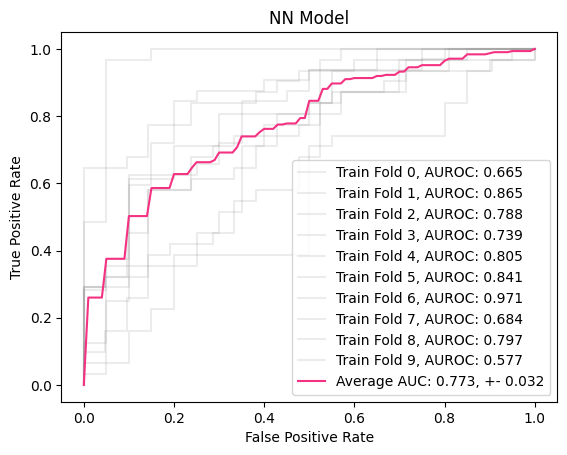

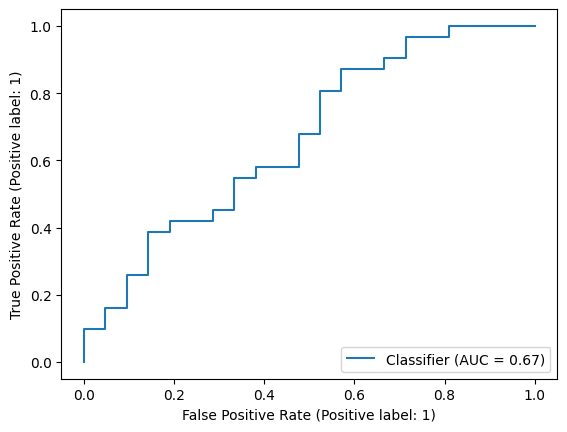

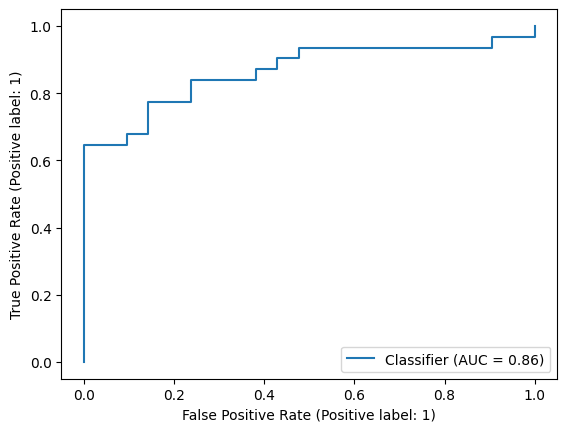

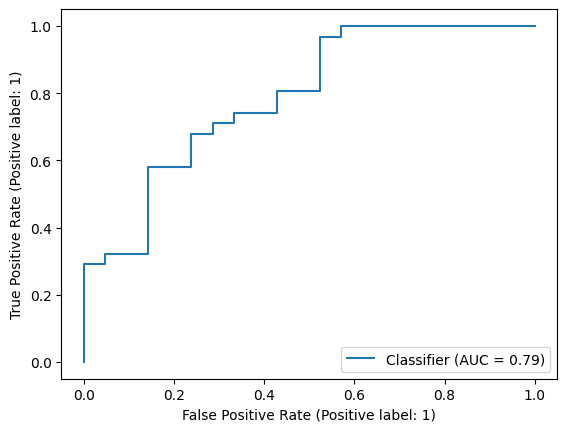

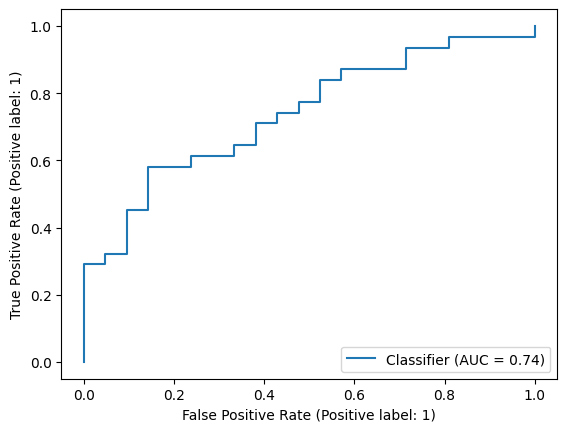

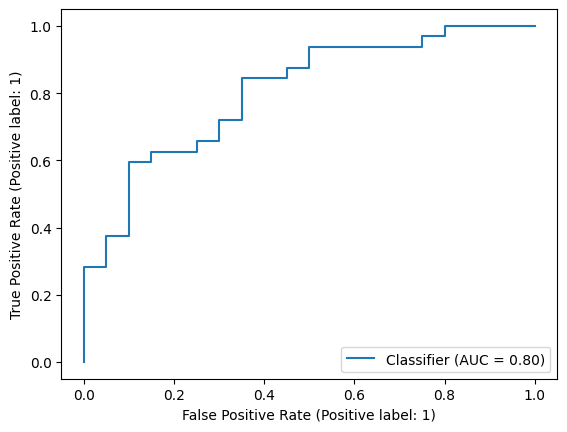

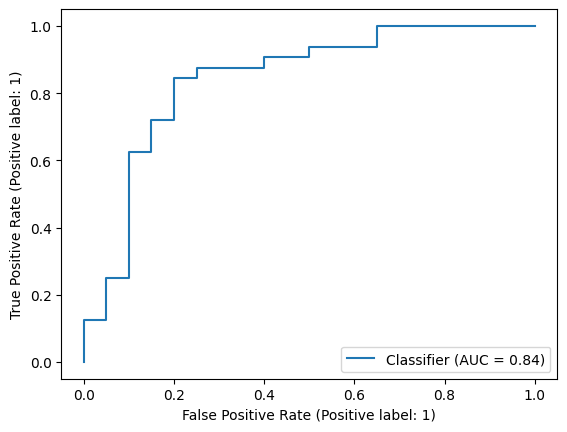

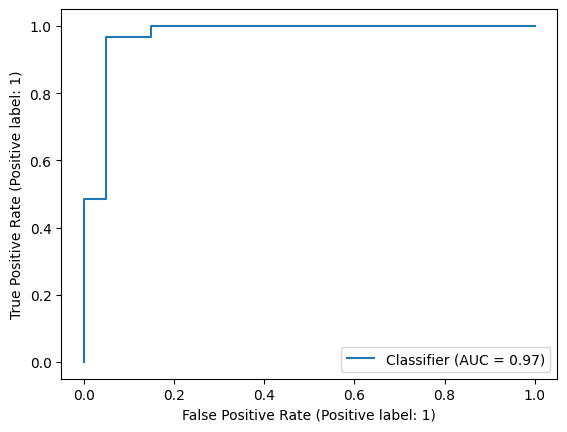

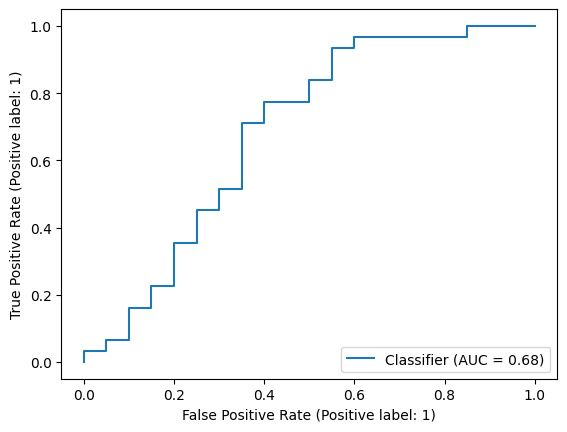

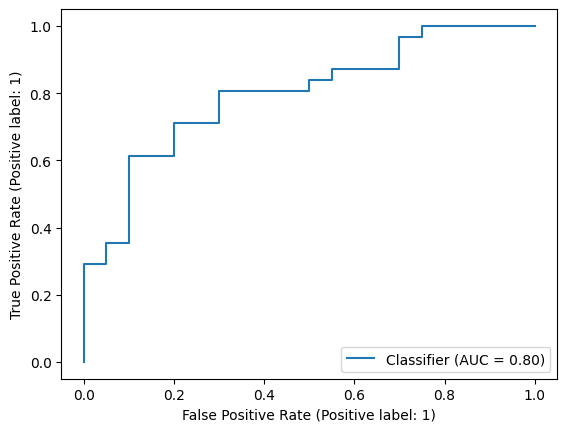

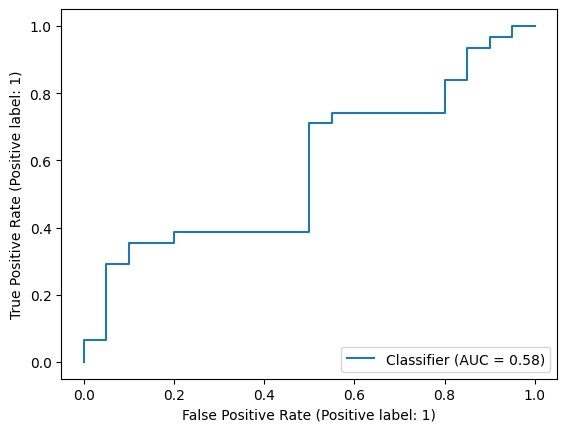

In [428]:
fig, ax = plt.subplots()

tf_metrics = {}
folds = 10
tprs = []
base_fpr = np.linspace(0, 1, 101)
metrics = {"accuracy": keras.metrics.BinaryAccuracy(), "auc": sklearn.metrics.roc_auc_score}
skf = uu.StratifiedKFold(10)

for j, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    tf_metrics[j] = {}
    model_cln = keras.models.clone_model(tf_model)
    model_cln.build((None, 4005)) # replace 10 with number of variables in input layer
    model_cln.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", 
                      metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])
    #model_cln.set_weights(tf_model.get_weights())

    fold_x_train, fold_x_test = x_train[train_index], x_train[test_index]
    fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

    model_cln.fit(fold_x_train, fold_y_train, epochs=4, validation_data=(fold_x_test, fold_y_test))
    test_pred = model_cln.predict(fold_x_test).ravel()

    for metric_name, metric_fn in metrics.items():
        tf_metrics[j][metric_name] = metric_fn(fold_y_test, test_pred)
    #test_pred = test_pred[:, 0]
    #probs = model_cln.predict_proba(fold_x_test)[:, 1]
  #  print(probs)
    viz_data = sklearn.metrics.RocCurveDisplay.from_predictions(fold_y_test, test_pred)
    fpr = viz_data.fpr
    tpr = viz_data.tpr
    #fpr, tpr, _ = sklearn.metrics.roc_curve(fold_y_test, probs)

    tf_metrics[j]["fpr_tpr"] = (fpr, tpr)

    #roc = sklearn.metrics.RocCurveDisplay.from_estimator(model_cln, fold_x_test, fold_y_test).plot(ax)
    roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Train Fold {j}, AUROC: {np.round(tf_metrics[j]['auc'], 3)}")
    tf_metrics[j]["roc_plot"] = roc

    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    #print(f"Training model {model_name}, fold {j}/{folds} prop 1 train: {fold_y_train.mean()}, prop 1  test: {fold_y_test.mean()}")
    print("\r", f"Training model NN, fold {j}/{folds}", end="")

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)

aucs = [m['auc'] for _, m in tf_metrics.items()]
mean_auc = np.mean(aucs)
sd_auc = np.std(aucs)

ci = 0.95 * sd_auc / np.sqrt(len(aucs))

ax.plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="NN Model")

In [447]:
tf_model = build_model(seed=1, alpha=0.005)
tf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])
tf_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)

Epoch 1/3
17/17 [==============================] - 3s 100ms/step - loss: 8.0476 - binary_accuracy: 0.6124 - auc_210: 0.6218 - val_loss: 5.8228 - val_binary_accuracy: 0.7000 - val_auc_210: 0.8130
Epoch 2/3
17/17 [==============================] - 2s 90ms/step - loss: 4.5829 - binary_accuracy: 0.7306 - auc_210: 0.7790 - val_loss: 3.4295 - val_binary_accuracy: 0.7000 - val_auc_210: 0.8485
Epoch 3/3
17/17 [==============================] - 1s 72ms/step - loss: 2.7375 - binary_accuracy: 0.7829 - auc_210: 0.8598 - val_loss: 2.2108 - val_binary_accuracy: 0.8000 - val_auc_210: 0.8672


In [448]:
import tqdm

fcs = []
bcs = []

for i in tqdm.tqdm(range(inputs.shape[0])):
    with tf.GradientTape() as tape:
        ins = tf.Variable(inputs[i][np.newaxis, :])
        out = tf_model(ins, training=False)
        grad = tape.gradient(out, ins)
        
        fcs.append(np.abs(hv.convert_triangle_to_mat(grad.numpy()[0])))
        bcs.append(np.abs(hv.convert_triangle_to_mat(inputs[i])))
        

100%|█████████████████████████████████████████| 646/646 [00:16<00:00, 39.82it/s]


[Text(0.5, 0, 'ROI'), Text(0, 0.5, 'Centrality')]

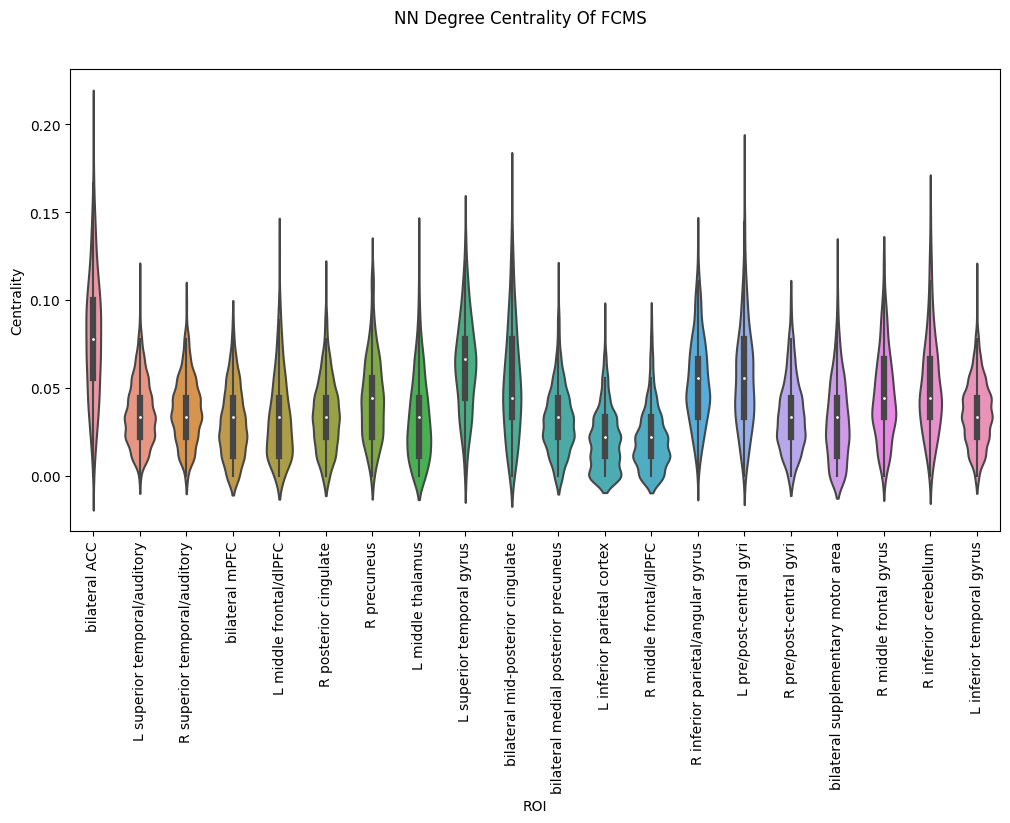

In [449]:
fbfcs = [f*b for f, b in zip(fcs, bcs)]
fbfcs_thresh = [hv.binarize(hv.threshold(f)) for f in fbfcs]
centrals = np.array([hv.degree_centrality(f) for f in fbfcs_thresh])

median_centrals = np.median(centrals.T, axis=1)
indices = np.argpartition(median_centrals, -20)[-20:]
df = hv.convert_centralities_to_df(centrals, indices)
order = None#hv.get_sorted_order(df, indices)

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality", order=order)
plt.xticks(rotation=90)
fig.suptitle("NN Degree Centrality Of FCMS")
ax.set(xlabel="ROI", ylabel="Centrality")

In [278]:
os.makedirs("out/functional_connectivity/nn", exist_ok=True)
with open("out/functional_connectivity/nn/thresh_fcms.npy", "wb+") as f:
    np.save(f, fbfcs_thresh)

with open("out/functional_connectivity/nn/fcms.npy", "wb+") as f:
    np.save(f, fbfcs)

# Tensorflow NN Model With Ensemble (Interpretable)

In [206]:
import tensorflow as tf
import tensorflow.keras as keras

In [450]:
pool_dims = 10

def build_model(seed=1, alpha=0.05):
    if seed is not None:
        tf.random.set_seed(seed)
        np.random.seed(seed)
        tf.keras.utils.set_random_seed(seed)

    
    tf_model = keras.Sequential([
        keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.L2(alpha), activation=None),
        keras.layers.LeakyReLU(0.3),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(100, kernel_regularizer=keras.regularizers.L2(alpha), activation=None),
        keras.layers.LeakyReLU(0.3),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(pool_dims, activation="tanh", kernel_regularizer=keras.regularizers.L2(alpha)),
    ])
    
    tf_model.build((None, 4005))
    return tf_model

tf_model = build_model(seed=1, alpha=0.005)
tf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mse", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])


Epoch 1/4
15/15 [==============================] - 3s 93ms/step - loss: 9.7336 - binary_accuracy: 0.2470 - auc_199: 0.0000e+00 - val_loss: 9.5596 - val_binary_accuracy: 0.0692 - val_auc_199: 0.0000e+00
Epoch 2/4
15/15 [==============================] - 1s 73ms/step - loss: 9.1674 - binary_accuracy: 0.2450 - auc_199: 0.0000e+00 - val_loss: 9.1221 - val_binary_accuracy: 0.1135 - val_auc_199: 0.0000e+00
Epoch 3/4
15/15 [==============================] - 1s 69ms/step - loss: 8.6203 - binary_accuracy: 0.2472 - auc_199: 0.0000e+00 - val_loss: 8.6366 - val_binary_accuracy: 0.1192 - val_auc_199: 0.0000e+00
Epoch 4/4
2/2 [==============================] - 0s 10ms/step
 Training model NN, fold 0/10Epoch 1/4
15/15 [==============================] - 2s 92ms/step - loss: 9.7434 - binary_accuracy: 0.2198 - auc_200: 0.0000e+00 - val_loss: 9.5145 - val_binary_accuracy: 0.0308 - val_auc_200: 0.0000e+00
Epoch 2/4
15/15 [==============================] - 1s 71ms/step - loss: 9.1864 - binary_accuracy: 0.2

Epoch 2/4
15/15 [==============================] - 1s 68ms/step - loss: 9.2334 - binary_accuracy: 0.1286 - auc_208: 0.0000e+00 - val_loss: 9.1925 - val_binary_accuracy: 0.3098 - val_auc_208: 0.0000e+00
Epoch 3/4
15/15 [==============================] - 1s 68ms/step - loss: 8.7092 - binary_accuracy: 0.2671 - auc_208: 0.0000e+00 - val_loss: 8.7985 - val_binary_accuracy: 0.4275 - val_auc_208: 0.0000e+00
Epoch 4/4
2/2 [==============================] - 0s 7ms/step
 Training model NN, fold 9/10

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'Pooled NN Model')]

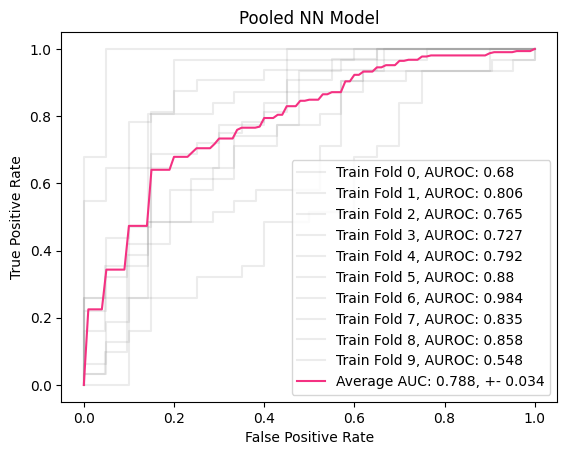

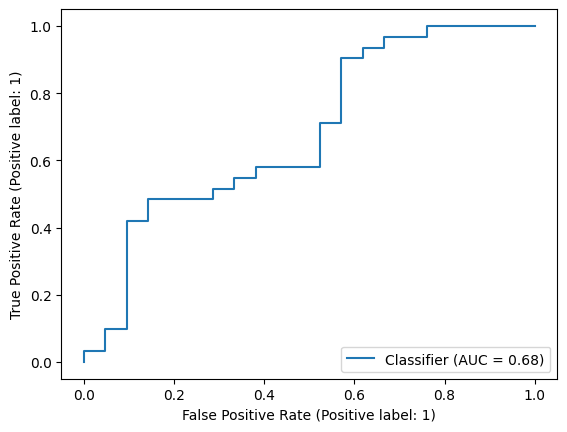

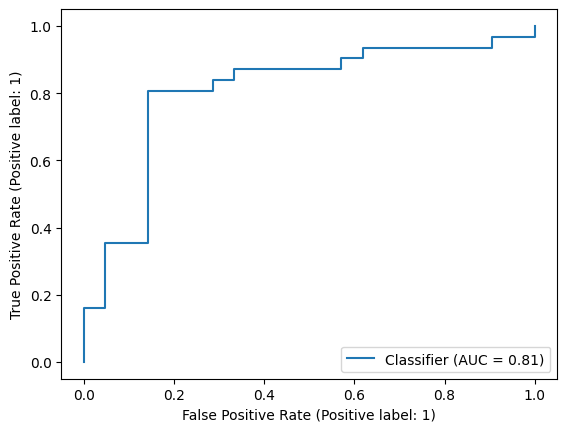

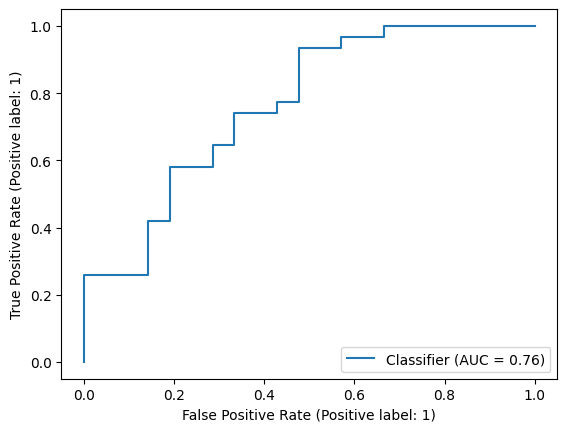

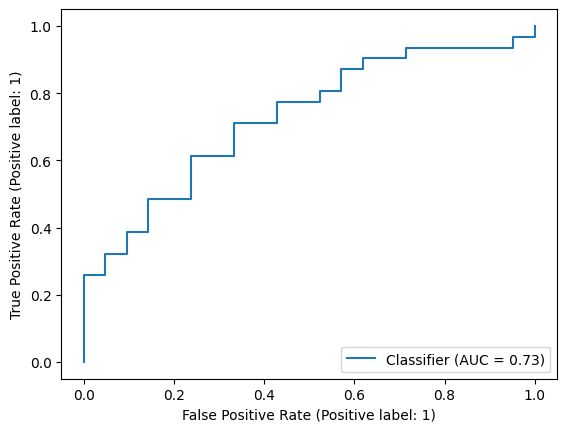

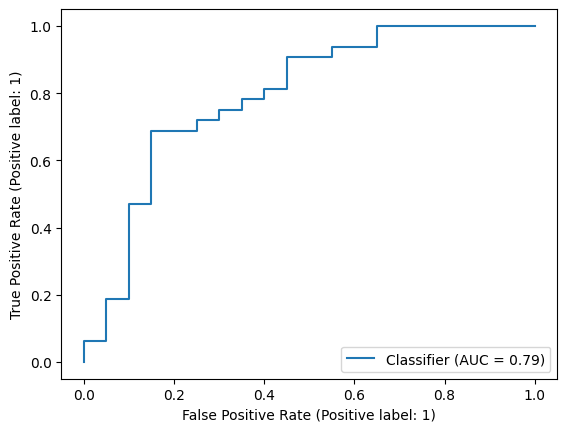

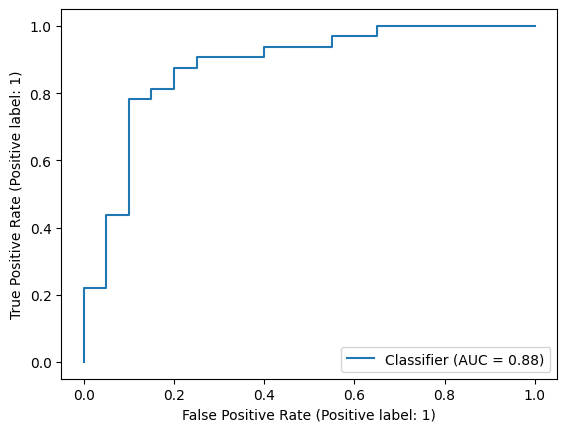

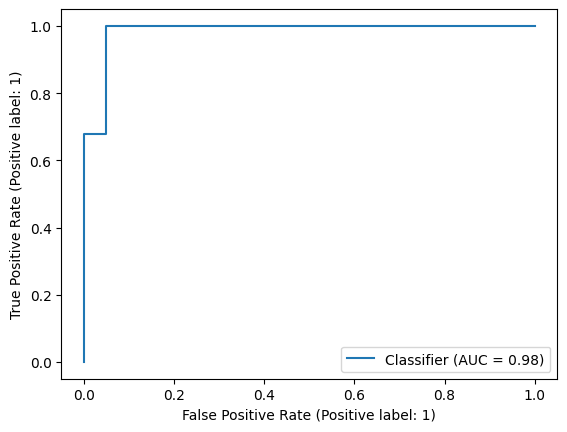

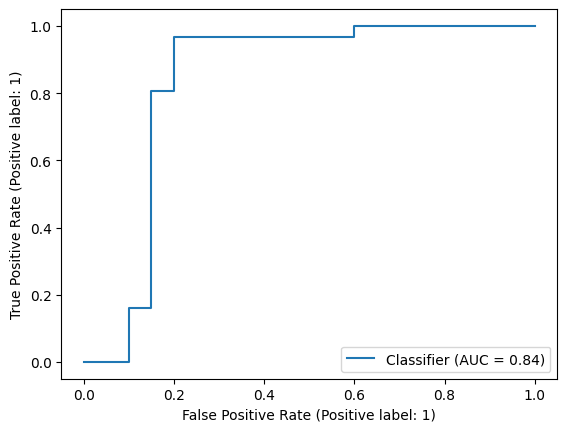

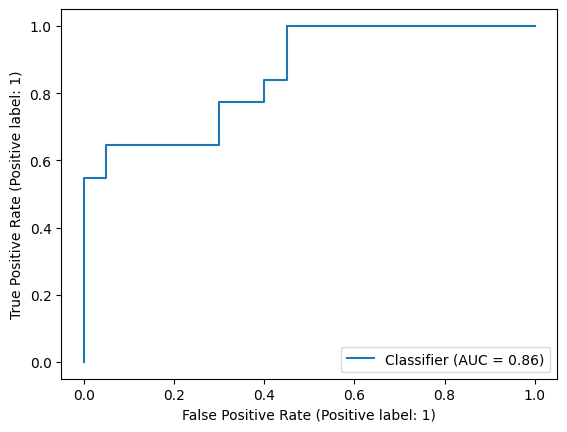

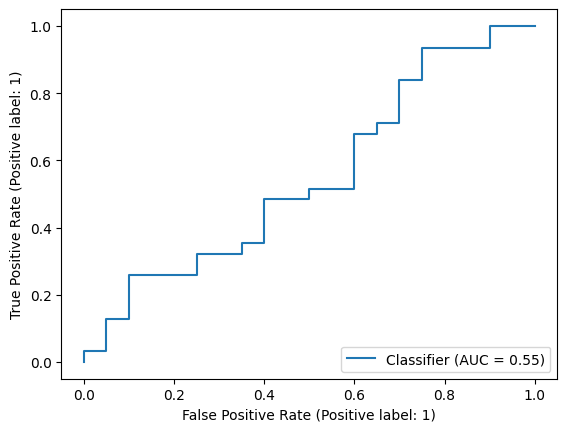

In [431]:
fig, ax = plt.subplots()

tf_metrics = {}
folds = 10
tprs = []
base_fpr = np.linspace(0, 1, 101)
metrics = {"accuracy": keras.metrics.BinaryAccuracy(), "auc": sklearn.metrics.roc_auc_score}
skf = uu.StratifiedKFold(10)

for j, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    tf_metrics[j] = {}
    model_cln = keras.models.clone_model(tf_model)
    model_cln.build((None, 4005)) # replace 10 with number of variables in input layer
    model_cln.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mse", 
                      metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])
    #model_cln.set_weights(tf_model.get_weights())

    fold_x_train, fold_x_test = x_train[train_index], x_train[test_index]
    fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

    model_cln.fit(fold_x_train, fold_y_train[:, np.newaxis].repeat(pool_dims, axis=1)*2-1, epochs=4, 
                  validation_data=(fold_x_test, fold_y_test[:, np.newaxis].repeat(pool_dims, axis=1)*2-1))
    test_pred = (model_cln.predict(fold_x_test).mean(axis=1)+1)/2#tf.math.sigmoid(model_cln.predict(fold_x_test).mean(axis=1))

    for metric_name, metric_fn in metrics.items():
        tf_metrics[j][metric_name] = metric_fn(fold_y_test, test_pred)
    #test_pred = test_pred[:, 0]
    #probs = model_cln.predict_proba(fold_x_test)[:, 1]
  #  print(probs)
    viz_data = sklearn.metrics.RocCurveDisplay.from_predictions(fold_y_test, test_pred)
    fpr = viz_data.fpr
    tpr = viz_data.tpr
    #fpr, tpr, _ = sklearn.metrics.roc_curve(fold_y_test, probs)

    tf_metrics[j]["fpr_tpr"] = (fpr, tpr)

    #roc = sklearn.metrics.RocCurveDisplay.from_estimator(model_cln, fold_x_test, fold_y_test).plot(ax)
    roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Train Fold {j}, AUROC: {np.round(tf_metrics[j]['auc'], 3)}")
    tf_metrics[j]["roc_plot"] = roc

    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    #print(f"Training model {model_name}, fold {j}/{folds} prop 1 train: {fold_y_train.mean()}, prop 1  test: {fold_y_test.mean()}")
    print("\r", f"Training model NN, fold {j}/{folds}", end="")

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)

aucs = [m['auc'] for _, m in tf_metrics.items()]
mean_auc = np.mean(aucs)
sd_auc = np.std(aucs)

ci = 0.95 * sd_auc / np.sqrt(len(aucs))

ax.plot(base_fpr, mean_tprs, color="#F43182", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="Pooled NN Model")


Epoch 1/3
17/17 [==============================] - 4s 117ms/step - loss: 8.2791 - binary_accuracy: 0.4304 - auc_212: 0.0000e+00 - val_loss: 5.5542 - val_binary_accuracy: 0.4862 - val_auc_212: 0.0000e+00
Epoch 2/3
17/17 [==============================] - 2s 97ms/step - loss: 4.3467 - binary_accuracy: 0.4291 - auc_212: 0.0000e+00 - val_loss: 2.9839 - val_binary_accuracy: 0.4731 - val_auc_212: 0.0000e+00
Epoch 3/3
5/5 [==============================] - 0s 11ms/step


(0.8461538461538461, 0.8735207100591715)

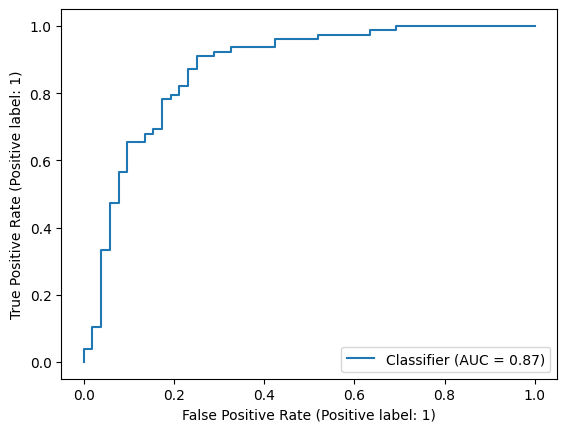

In [451]:

tf_model = build_model(alpha=0.005, seed=1)
tf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                 loss="mse", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])
tf_model.fit(x_train, y_train[:, np.newaxis].repeat(pool_dims, axis=1)*2-1, 
             validation_data=(x_test, y_test[:, np.newaxis].repeat(pool_dims,axis=1)*2-1), epochs=3)

test_pred = (tf_model.predict(x_test).mean(axis=1) + 1)/2 #tf.math.sigmoid(tf_model.predict(x_test).mean(axis=1))
#print((tf_model.predict(x_test).mean(axis=1) + 1)/2, tf.math.sigmoid(tf_model.predict(x_test).mean(axis=1)))
sklearn.metrics.accuracy_score(np.round(test_pred), y_test), sklearn.metrics.RocCurveDisplay.from_predictions(y_test, test_pred).roc_auc

In [452]:
import tqdm

fcs = []
bcs = []

for i in tqdm.tqdm(range(inputs.shape[0])):
    with tf.GradientTape() as tape:
        ins = tf.Variable(inputs[i][np.newaxis, :])
        out = tf_model(ins, training=False)
        grad = tape.gradient(out, ins)
        
        fcs.append(np.abs(hv.convert_triangle_to_mat(grad.numpy()[0])))
        bcs.append(np.abs(hv.convert_triangle_to_mat(inputs[i])))
        

100%|█████████████████████████████████████████| 646/646 [00:16<00:00, 38.06it/s]


[Text(0.5, 0, 'ROI'), Text(0, 0.5, 'Centrality')]

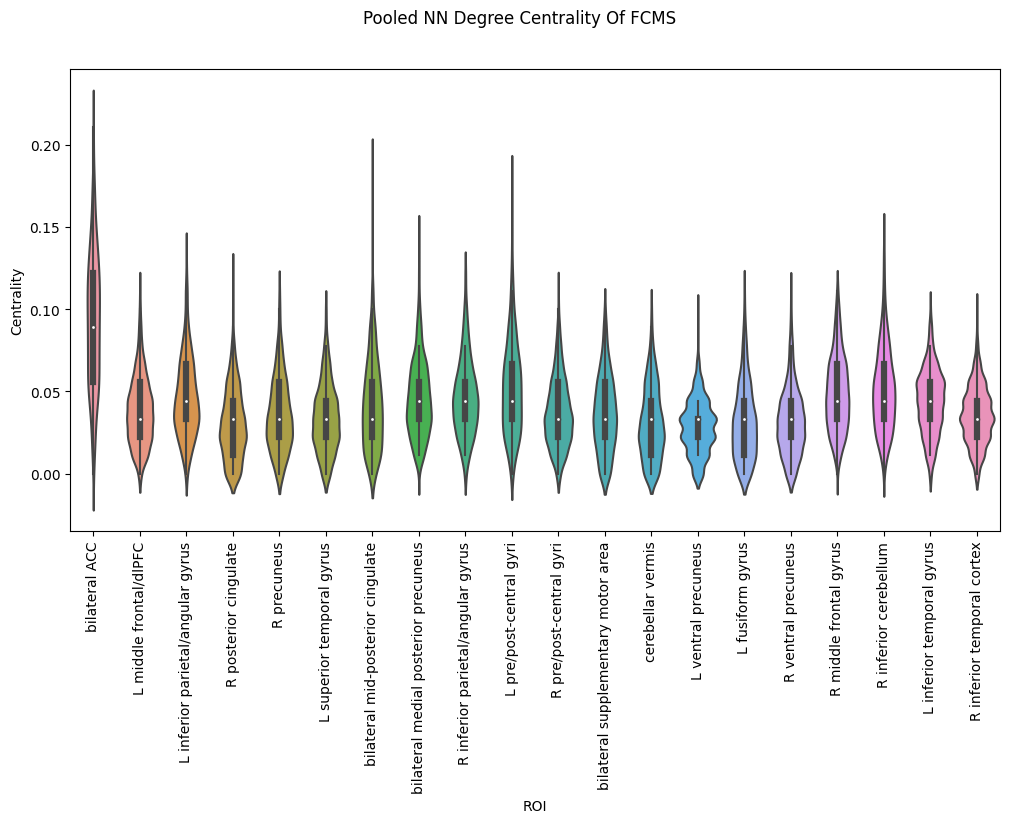

In [455]:
fbfcs = [f*b for f, b in zip(fcs, bcs)]
fbfcs_thresh = [hv.binarize(hv.threshold(f*b)) for f, b in zip(fcs, bcs)]
centrals = np.array([hv.degree_centrality(f) for f in fbfcs_thresh])

median_centrals = np.median(centrals.T, axis=1)
indices = np.argpartition(median_centrals, -20)[-20:]
df = hv.convert_centralities_to_df(centrals, indices)
order = None#hv.get_sorted_order(df, indices)

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality", order=order)
plt.xticks(rotation=90)
fig.suptitle("Pooled NN Degree Centrality Of FCMS")
ax.set(xlabel="ROI", ylabel="Centrality")

In [246]:
sims = [hv.cosim(centrals[i], control_centrals[i]) for i in range(centrals.shape[0])]
np.mean(sims)

0.7219334382387396

In [247]:
os.makedirs("out/functional_connectivity/pooled_nn", exist_ok=True)
with open("out/functional_connectivity/pooled_nn/thresh_fcms.npy", "wb+") as f:
    np.save(f, fbfcs_thresh)

with open("out/functional_connectivity/pooled_nn/fcms.npy", "wb+") as f:
    np.save(f, fbfcs)

# Regression Based Approach

In [42]:
train_file = np.load("data/standard_fcs_labels_training.npz")

labels = train_file["labels"]
inputs = train_file["standard_fcs"]

len(labels), inputs.shape

(646, (646, 4005))

In [46]:
train_file